#  Data Description

* Folder name: Details
* dawn : existed data with 6 class (train class removed)
* split_yolo : train val split with 80-20 ratio
* crossval_fold_(1-5) : 5-fold cross validation data
* augemnted dawn : augemneted version of dataset. only minority class instances are augmented. Change foldname to do with different folder data

In [1]:
#Create a requirements.txt file with the ultralytics package
with open("requirements.txt", "w") as f:
    f.write("ultralytics\n")

In [2]:
!pip install -r /kaggle/working/requirements.txt
    
# # Install ultralytics
# !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.1

In [3]:
# # Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Optional: get current GPU index
    current_gpu = torch.cuda.current_device()
    print(f"Currently active GPU index: {current_gpu}")
else:
    print("No GPU available. Running on CPU.")

Using torch 2.6.0+cu124 (Tesla P100-PCIE-16GB)
Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB
Currently active GPU index: 0


In [4]:
import time
import gc
time.sleep(5) 
gc.collect()

96

In [5]:
import os
import shutil
import pandas as pd
import random
import cv2
import shutil
from tqdm import tqdm
import glob
import numpy as np
from albumentations import *
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-31 02:28:41.133135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748658521.325798      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748658521.382321      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.18.0
Keras Version: 3.8.0


In [6]:
# seed = random.randint(0, 1000)
seed=1008
# Set random seeds
os.environ["PYTHONHASHSEED"]=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 1008


In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"{path} Folder Created Succesfully")

# Find Number Of Class and Their Occurance

In [8]:
least_class_filename=""

folder_path = "/kaggle/input/dawn-dataset/labels"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

data=[]
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              parts = line.strip().split('\n')  # Split by newline and remove leading/trailing whitespace
              # print(parts[0])
              for part in parts:
                # print(part[0])
                data.append(part[0])
                if(part[0]=='7'):
                  # print(file_name)
                  least_class_filename=file_name
                # data.append(parts)
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print(least_class_filename)

snow_storm-307.txt


In [9]:
avoid_file_id=least_class_filename.split(".")[0]
avoid_file_id

'snow_storm-307'

In [10]:
# data
df = pd.DataFrame(data)

# Rename the second column (index 1) to 'level'
# if len(df.columns) > 1:
#   df.rename(columns={df.columns[1]: 'level'}, inplace=True)
df.rename(columns={df.columns[0]: 'level'}, inplace=True)
level_counts = df['level'].value_counts()
level_counts

level
3    6454
8     646
1     477
6     161
4      81
2      26
7       1
Name: count, dtype: int64

# Remove Least Class with 1 Appearnce

In [11]:
main_path="/kaggle/working/dawn"
create_dir(main_path)
img_path="/kaggle/working/dawn/images"
create_dir(img_path)
lab_path="/kaggle/working/dawn/labels"
create_dir(lab_path)

/kaggle/working/dawn Folder Created Succesfully
/kaggle/working/dawn/images Folder Created Succesfully
/kaggle/working/dawn/labels Folder Created Succesfully


In [12]:
# Source and destination directories
source_folder = '/kaggle/input/dawn-dataset/labels'
destination_folder = '/kaggle/working/dawn/labels'

# Copy all files
for filename in os.listdir(source_folder):
    # print(filename.split(".")[0])
    if(filename.split(".")[0]==avoid_file_id):
        print(f"Do Not Copy this file {filename}")
    else:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        
        if os.path.isfile(source_path):
            shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
            # print(f"Copied: {filename}")

Do Not Copy this file snow_storm-307.txt


In [13]:
# Source and destination directories
source_folder = '/kaggle/input/dawn-dataset/images'
destination_folder = '/kaggle/working/dawn/images'

# Copy all files
for filename in os.listdir(source_folder):
    # print(filename.split(".")[0])
    if(filename.split(".")[0]==avoid_file_id):
        print(f"Do Not Copy this file {filename}")
    else:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        
        if os.path.isfile(source_path):
            shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
            # print(f"Copied: {filename}")

Do Not Copy this file snow_storm-307.jpg


In [14]:
folder_path = "/kaggle/working/dawn/labels"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

data=[]
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              parts = line.strip().split('\n')  # Split by newline and remove leading/trailing whitespace
              # print(parts[0])
              for part in parts:
                # print(part[0])
                data.append(part[0])
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
# data
df = pd.DataFrame(data)
df.rename(columns={df.columns[0]: 'level'}, inplace=True)
level_counts = df['level'].value_counts()
level_counts

level
3    6447
8     646
1     473
6     161
4      81
2      26
Name: count, dtype: int64

# Re-Arrange Class ID
**Truck: 8=>0**

**Bus: 6=>5**

**Person: 1**

**Bicycle: 2**

**Car: 3**

**Motorcycle: 4**


In [15]:
def modify_file(file_path):
    """Modifies a file by replacing '6' at the beginning of a line with '5'."""
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        modified_lines = []
        for line in lines:
            parts = line.strip().split('\n')
            for i in range(len(parts)):
                if parts[i].startswith("6"):
                    parts[i] = "5" + parts[i][1:]

                if parts[i].startswith("8"):
                    parts[i] = "0" + parts[i][1:]
            modified_lines.extend(parts)
        with open(file_path, 'w') as file:
            file.write('\n'.join(modified_lines))

    except Exception as e:
        print(f"Error modifying file {file_path}: {e}")


folder_path = "/kaggle/working/dawn/labels/"
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    modify_file(file_path)

In [16]:
folder_path = "/kaggle/working/dawn/labels"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

data=[]
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              parts = line.strip().split('\n')  # Split by newline and remove leading/trailing whitespace
              # print(parts[0])
              for part in parts:
                # print(part[0])
                data.append(part[0])
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
# data
df = pd.DataFrame(data)
df.rename(columns={df.columns[0]: 'level'}, inplace=True)
level_counts = df['level'].value_counts()
level_counts

level
3    6447
0     646
1     473
5     161
4      81
2      26
Name: count, dtype: int64

# Find all file names where least class exist

In [17]:
folder_path = "/kaggle/working/dawn/labels"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

filename=[]
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              parts = line.strip().split('\n')  # Split by newline and remove leading/trailing whitespace
              # print(parts[0])
              for part in parts:
                if(part[0]=="2" or part[0]=="4" or part[0]=="5"):
                    print(file_name)
                    print(line)
                    filename.append(file_path)
                    break
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

rain_storm-395.txt
5 0.671484375 0.29871175523349436 0.10703125 0.14009661835748793
rain_storm-740.txt
5 0.79609375 0.6364265927977839 0.09375 0.13157894736842105
dusttornado-003.txt
5 0.060625 0.7821670428893905 0.11875 0.22799097065462753

sand_storm-368.txt
5 0.375390625 0.5390218522372529 0.16953125 0.10197710718002082
sand_storm_g2_-932.txt
5 0.315625 0.6887456037514654 0.0703125 0.06916764361078546

sand_storm-065.txt
4 0.4140625 0.6395833333333333 0.015625 0.034722222222222224

sand_storm-065.txt
4 0.389453125 0.6555555555555556 0.01796875 0.041666666666666664

sand_storm-065.txt
4 0.371875 0.6430555555555556 0.0125 0.03888888888888889

sand_storm-065.txt
4 0.35546875 0.6743055555555556 0.0171875 0.043055555555555555

sand_storm-065.txt
4 0.253125 0.6673611111111111 0.0171875 0.04027777777777778

sand_storm-065.txt
4 0.48828125 0.7340277777777777 0.0359375 0.09027777777777778

sand_storm-065.txt
4 0.661328125 0.6673611111111111 0.02421875 0.06527777777777778

sand_storm-065.txt


In [18]:
len(filename)

268

In [19]:
filename = list(set(filename))
print(len(filename))
filename

155


['/kaggle/working/dawn/labels/foggy-024.txt',
 '/kaggle/working/dawn/labels/snow_storm-077.txt',
 '/kaggle/working/dawn/labels/foggy-037.txt',
 '/kaggle/working/dawn/labels/haze-119.txt',
 '/kaggle/working/dawn/labels/foggy-077.txt',
 '/kaggle/working/dawn/labels/rain_storm-839.txt',
 '/kaggle/working/dawn/labels/sand_storm-284.txt',
 '/kaggle/working/dawn/labels/sand_storm-902.txt',
 '/kaggle/working/dawn/labels/foggy-090.txt',
 '/kaggle/working/dawn/labels/sand_storm-133.txt',
 '/kaggle/working/dawn/labels/snow_storm-202.txt',
 '/kaggle/working/dawn/labels/dusttornado-035.txt',
 '/kaggle/working/dawn/labels/snow_storm-245.txt',
 '/kaggle/working/dawn/labels/sand_storm-989.txt',
 '/kaggle/working/dawn/labels/haze-028.txt',
 '/kaggle/working/dawn/labels/haze-020.txt',
 '/kaggle/working/dawn/labels/haze-046.txt',
 '/kaggle/working/dawn/labels/sand_storm-042.txt',
 '/kaggle/working/dawn/labels/snow_storm-065.txt',
 '/kaggle/working/dawn/labels/sand_storm-166.txt',
 '/kaggle/working/dawn/

In [20]:
for files in filename:
    file_path = files
    print(files)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              print(line)
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

/kaggle/working/dawn/labels/foggy-024.txt
3 0.1671875 0.5358072916666666 0.3234375 0.4153645833333333

3 0.813671875 0.4947916666666667 0.21796875 0.3020833333333333

3 0.6609375 0.4700520833333333 0.159375 0.234375

1 0.11640625 0.537109375 0.1734375 0.4205729166666667

4 0.088671875 0.638671875 0.10859375 0.2747395833333333
/kaggle/working/dawn/labels/snow_storm-077.txt
3 0.11015625 0.89375 0.2125 0.20972222222222223

3 0.471875 0.64375 0.1359375 0.2125

3 0.293359375 0.7895833333333333 0.14296875 0.2263888888888889

3 0.283984375 0.4423611111111111 0.10546875 0.13194444444444445

3 0.391796875 0.3236111111111111 0.11640625 0.09444444444444444

3 0.5 0.17291666666666666 0.0578125 0.07361111111111111

3 0.279296875 0.6520833333333333 0.12109375 0.1625

3 0.276171875 0.5451388888888888 0.15859375 0.1763888888888889

3 0.2859375 0.35208333333333336 0.1609375 0.13472222222222222

3 0.41484375 0.2638888888888889 0.05625 0.06944444444444445

3 0.390234375 0.22708333333333333 0.04765625 0.0

In [21]:
def label_distribution(folder_path):
    data = []

    # Collect label values
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    stripped_line = line.strip()
                    if stripped_line:  # ignore empty lines
                        label = stripped_line[0]  # take first character (class index)
                        data.append(label)
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")

    # Create DataFrame and count occurrences
    df = pd.DataFrame(data, columns=['level'])
    level_counts = df['level'].value_counts().sort_index()
    print(level_counts)

    # Plot pie chart
    labels = [f"Level {label}" for label in level_counts.index]
    sizes = level_counts.values

    plt.figure(figsize=(5, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Label Distribution by Class Level')
    plt.axis('equal')
    plt.show()

# 5 Fold Cross-Validation

In [22]:
!pip install iterative-stratification
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [23]:
image_dir = "/kaggle/working/dawn/images"
label_dir = "/kaggle/working/dawn/labels"
output_dir = "/kaggle/working/dawn_5_fold"
create_dir(output_dir )

/kaggle/working/dawn_5_fold Folder Created Succesfully


In [24]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# Paths
num_folds = 5

# Get label and image files
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
image_files = [f.replace('.txt', '.jpg') for f in label_files]  # change to .png if needed

# Get all classes in the dataset
all_classes = set()
image_classes = []

print("Analyzing label files...")
for label_file in tqdm(label_files):
    class_ids = set()
    with open(os.path.join(label_dir, label_file), 'r') as f:
        for line in f:
            if line.strip():
                class_id = int(line.strip().split()[0])
                class_ids.add(class_id)
    all_classes.update(class_ids)
    image_classes.append(class_ids)

# Create binary multi-hot encoding per image
all_classes = sorted(list(all_classes))
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}

y = np.zeros((len(label_files), len(all_classes)), dtype=int)
for i, cls_set in enumerate(image_classes):
    for cls in cls_set:
        y[i, class_to_index[cls]] = 1

X = np.array(label_files)

# Perform multi-label stratified split
mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y)):
    fold_dir = os.path.join(output_dir, f'fold{fold+1}')
    os.makedirs(os.path.join(fold_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'val', 'labels'), exist_ok=True)

    for idxs, split in zip([train_idx, val_idx], ['train', 'val']):
        for i in idxs:
            img_name = image_files[i]
            label_name = label_files[i]
            shutil.copy(os.path.join(image_dir, img_name), os.path.join(fold_dir, split, 'images', img_name))
            shutil.copy(os.path.join(label_dir, label_name), os.path.join(fold_dir, split, 'labels', label_name))

    print(f"✅ Fold {fold+1} created | Train: {len(train_idx)}, Val: {len(val_idx)}")

Analyzing label files...


100%|██████████| 1026/1026 [00:00<00:00, 33460.25it/s]


✅ Fold 1 created | Train: 821, Val: 205
✅ Fold 2 created | Train: 821, Val: 205
✅ Fold 3 created | Train: 820, Val: 206
✅ Fold 4 created | Train: 821, Val: 205
✅ Fold 5 created | Train: 821, Val: 205


Folders found:
Label Distribution in  Train fold2
level
0     509
1     393
2      22
3    5173
4      72
5     124
Name: count, dtype: int64


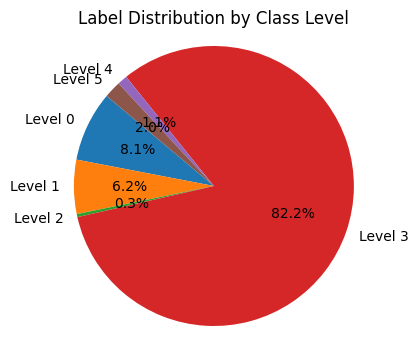

Label Distribution in  Val fold2
level
0     137
1      80
2       4
3    1274
4       9
5      37
Name: count, dtype: int64


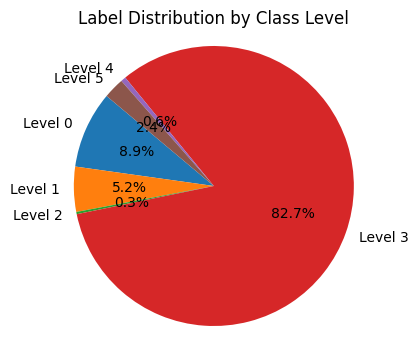

Label Distribution in  Train fold5
level
0     504
1     378
2      20
3    5217
4      61
5     131
Name: count, dtype: int64


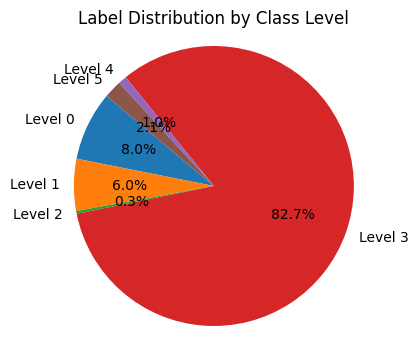

Label Distribution in  Val fold5
level
0     142
1      95
2       6
3    1230
4      20
5      30
Name: count, dtype: int64


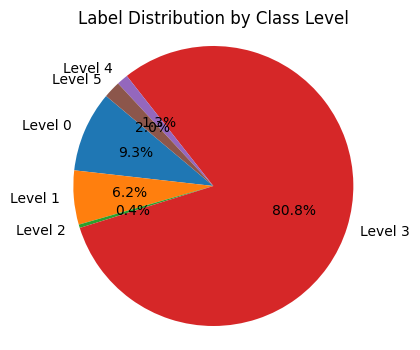

Label Distribution in  Train fold4
level
0     517
1     368
2      20
3    5227
4      63
5     130
Name: count, dtype: int64


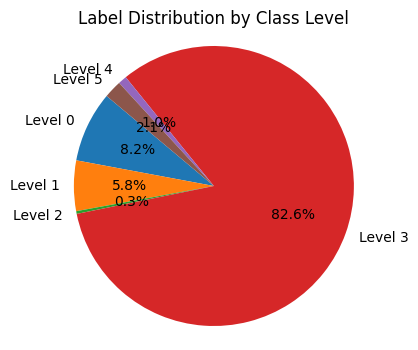

Label Distribution in  Val fold4
level
0     129
1     105
2       6
3    1220
4      18
5      31
Name: count, dtype: int64


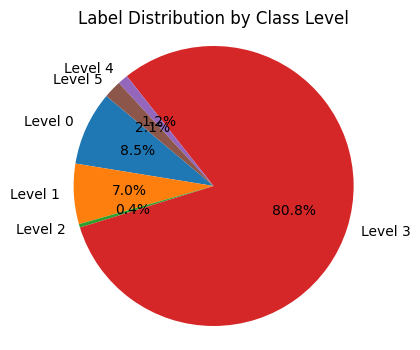

Label Distribution in  Train fold3
level
0     511
1     379
2      21
3    5072
4      60
5     129
Name: count, dtype: int64


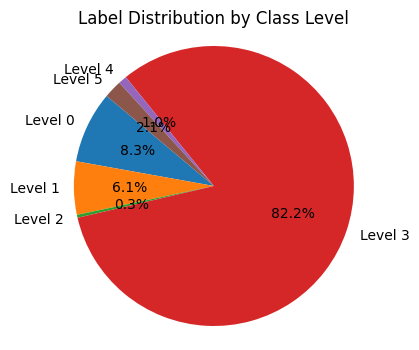

Label Distribution in  Val fold3
level
0     135
1      94
2       5
3    1375
4      21
5      32
Name: count, dtype: int64


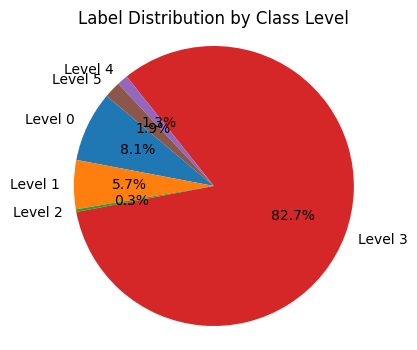

Label Distribution in  Train fold1
level
0     543
1     374
2      21
3    5099
4      68
5     130
Name: count, dtype: int64


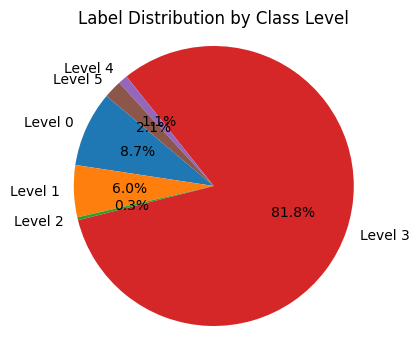

Label Distribution in  Val fold1
level
0     103
1      99
2       5
3    1348
4      13
5      31
Name: count, dtype: int64


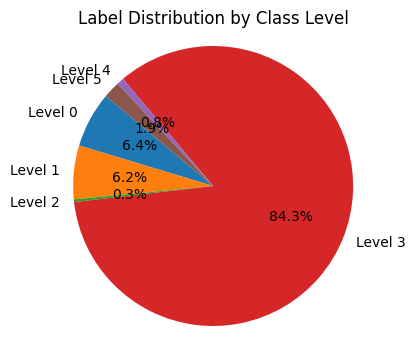

In [25]:
# Set your root directory
root_dir = '/kaggle/working/dawn_5_fold'

# Get all folder names in the root directory
folders = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

# Print the folder names
print("Folders found:")
for folder in folders:
    # print(folder)
    path=f"/{root_dir}/{folder}/train/labels"
    print(f"Label Distribution in  Train {folder}")
    label_distribution(path)
    path=f"/{root_dir}/{folder}/val/labels"
    print(f"Label Distribution in  Val {folder}")
    label_distribution(path)

# Data Augmentation

Find minor class filename

In [26]:
folder_path = "/kaggle/input/dawn-min/minimum_appearance"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

least_class=[]
for file_name in file_names:
    # print(file_name)
    least_class.append(file_name.split(".")[0])

print(f"length of least Instances:{len(least_class)}")
print(least_class)

length of least Instances:57
['haze-006', 'rain_storm-293', 'rain_storm-365', 'rain_storm-658', 'haze-013', 'mist-122', 'snow_storm-341', 'foggy-002', 'dusttornado-007', 'foggy-083', 'sand_storm-251', 'sand_storm-757', 'sand_storm-079', 'haze-081', 'foggy-041', 'sand_storm-086', 'rain_storm-176', 'sand_storm-008', 'rain_storm-381', 'mist-111', 'sand_storm-150', 'rain_storm-105', 'snow_storm-333', 'sand_storm-924', 'sand_storm-221', 'foggy-084', 'rain_storm-589', 'haze-074', 'rain_storm-685', 'haze-132', 'foggy-081', 'sand_storm-298', 'sand_storm-263', 'rain_storm-199', 'rain_storm-493', 'sand_storm-148', 'haze-065', 'rain_storm-126', 'foggy-012', 'rain_storm-563', 'rain_storm-002', 'snow_storm-018', 'snow_storm-027', 'sand_storm-157', 'rain_storm-610', 'snow_storm-281', 'foggy-092', 'foggy-072', 'rain_storm-004', 'rain_storm-005', 'mist-034', 'rain_storm-030', 'rain_storm-614', 'snow_storm-051', 'snow_storm-057', 'mist-039', 'haze-067']


In [27]:
folder_path = "/kaggle/working/dawn/labels"  # Replace with your folder path
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

file_2=[]
file_4=[]
file_5=[]
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r') as file:
            for line in file:
              parts = line.strip().split('\n')  # Split by newline and remove leading/trailing whitespace
              # print(parts[0])
              for part in parts:
                if(part[0]=="2"):
                    file_2.append(file_name.split(".")[0])
                if(part[0]=="4"):
                    file_4.append(file_name.split(".")[0])
                if(part[0]=="5"):
                    file_5.append(file_name.split(".")[0]) 
                
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print(len(file_2))
print(len(file_4))
print(len(file_5))

26
81
161


In [28]:
unique_values = list(set(file_2))
print(f"Unique  Images: {len(unique_values)}")
print(unique_values)

Unique  Images: 20
['sand_storm-177', 'haze-065', 'sand_storm-989', 'mist-190', 'mist-034', 'sand_storm_g2_-068', 'sand_storm-251', 'sand_storm_g2_-001', 'sand_storm-079', 'sand_storm-379', 'haze-054', 'haze-016', 'foggy-080', 'mist-035', 'sand_storm_g2_-004', 'sand_storm-130', 'mist-180', 'haze-129', 'snow_storm-028', 'haze-045']


In [29]:
unique_values = sorted(list(set(file_4)))
print(f"Unique  Images: {len(unique_values)}")
print(unique_values)

Unique  Images: 46
['dusttornado-012', 'foggy-002', 'foggy-004', 'foggy-010', 'foggy-024', 'foggy-027', 'haze-013', 'haze-020', 'haze-028', 'haze-041', 'haze-064', 'haze-074', 'haze-083', 'haze-093', 'haze-110', 'mist-034', 'mist-035', 'rain_storm-002', 'rain_storm-130', 'rain_storm-493', 'sand_storm-008', 'sand_storm-009', 'sand_storm-027', 'sand_storm-031', 'sand_storm-034', 'sand_storm-040', 'sand_storm-042', 'sand_storm-065', 'sand_storm-075', 'sand_storm-111', 'sand_storm-133', 'sand_storm-166', 'sand_storm-180', 'sand_storm-221', 'sand_storm-228', 'sand_storm-239', 'sand_storm-286', 'sand_storm-322', 'sand_storm-388', 'sand_storm-913', 'sand_storm-935', 'sand_storm_g2_-001', 'sand_storm_g2_-004', 'sand_storm_g2_-005', 'sand_storm_g2_-068', 'snow_storm-283']


In [30]:
unique_values =  sorted(list(set(file_5)))
print(f"Unique  Images: {len(unique_values)}")
print(unique_values)

Unique  Images: 106
['dusttornado-001', 'dusttornado-003', 'dusttornado-006', 'dusttornado-015', 'dusttornado-017', 'dusttornado-021', 'dusttornado-032', 'dusttornado-033', 'dusttornado-035', 'dusttornado-038', 'foggy-007', 'foggy-010', 'foggy-014', 'foggy-018', 'foggy-036', 'foggy-037', 'foggy-068', 'foggy-077', 'foggy-080', 'foggy-083', 'foggy-086', 'foggy-090', 'haze-016', 'haze-046', 'haze-048', 'haze-053', 'haze-054', 'haze-056', 'haze-069', 'haze-074', 'haze-092', 'haze-096', 'haze-119', 'haze-129', 'mist-002', 'mist-027', 'mist-035', 'mist-043', 'mist-049', 'mist-067', 'mist-074', 'mist-111', 'mist-115', 'mist-122', 'mist-148', 'mist-158', 'mist-163', 'mist-180', 'mist-189', 'rain_storm-019', 'rain_storm-106', 'rain_storm-130', 'rain_storm-207', 'rain_storm-339', 'rain_storm-351', 'rain_storm-395', 'rain_storm-662', 'rain_storm-692', 'rain_storm-740', 'rain_storm-839', 'rain_storm-855', 'rain_storm-901', 'sand_storm-009', 'sand_storm-014', 'sand_storm-058', 'sand_storm-129', 'sa

In [31]:
def file_count(path):
    print(path)
    folder_name = path.strip("/").split("/")[-1]
    print(f"Files in '{folder_name}' Folder:\n")

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            count = len(os.listdir(folder_path))
            print(f"{folder} folder contains\t\t{count} images")

**No augmentation for majority class.so just copy them**

In [32]:
def copy_data(file_path):
    # print("Inside Copy Data")
    file_name=file_path.split("/")[-1]
    src_path = file_path
    dest=file_path.split("/")[-4]+"/"+file_path.split("/")[-3]+"/"+file_path.split("/")[-2]+"/"+file_name
    # print(dest)
    dest_folder =os.path.join("/kaggle/working/augmented_dawn",dest)
    # print(src_path)
    # print(dest_folder)
    shutil.copy(src_path, dest_folder)

    txt_src=file_path.split("/")[1:6]
    # # print(img_src)
    src_path= "/"+txt_src[0]+"/"+ txt_src[1]+"/"+ txt_src[2]+"/"+ txt_src[3]+"/"+txt_src[4]+"/labels/"+file_name.split(".")[0]+".txt"
    # print(src_path)
    dest=file_path.split("/")[-4]+"/"+file_path.split("/")[-3]+"/labels/"+file_name.split(".")[0]+".txt"
    # print(dest)
    dest_folder =os.path.join("/kaggle/working/augmented_dawn",dest)
    # print(dest_folder)
    #copy img
    shutil.copy(src_path, dest_folder)
    

## Augmentation For Minoritry Class

In [33]:
def data_augementation(file_path,class_id):
    file_name=file_path.split("/")[-1]
    img_path = file_path
    # print(f"Image Source: {img_path}")
    txt_src=file_path.split("/")[1:6]
    # # print(img_src)
    txt_path= "/"+txt_src[0]+"/"+ txt_src[1]+"/"+ txt_src[2]+"/"+ txt_src[3]+"/"+txt_src[4]+"/labels/"+file_name.split(".")[0]+".txt"
    
    # print(f"lebel Source: {txt_path}")
    temp_path=file_path.split("/")[-4]+"/"+file_path.split("/")[-3]
    save_dir=os.path.join("/kaggle/working/augmented_dawn",temp_path)
    # print(f"Save To: {save_dir}")

    x = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if x is not None:
        
        if(class_id=="min" or class_id=="2"):
 
            aug= RandomBrightnessContrast(p=1)
            augmented=aug(image=x)
            x1=augmented["image"]
    
            aug = GaussianBlur(p=1, blur_limit=7)
            augmented=aug(image=x)
            x2=augmented["image"]
                
            aug= CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1)
            augmented=aug(image=x)
            x3=augmented["image"]
                
            aug=RandomGamma(p=1)
            augmented=aug(image=x)
            x4=augmented["image"]
                
            aug= HueSaturationValue(p=1)
            augmented=aug(image=x)
            x5=augmented["image"]
    
            aug= MedianBlur(blur_limit=7, p=1)
            augmented=aug(image=x)
            x6=augmented["image"]
                
            aug= RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1)
            augmented=aug(image=x)
            x7=augmented["image"]
                
            aug= Sharpen(p=1)
            augmented=aug(image=x)
            x8=augmented["image"]
                
            aug= ChannelShuffle(p=1)
            augmented=aug(image=x)
            x9=augmented["image"]
                
            aug= ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1)
            augmented=aug(image=x)
            x10=augmented["image"]

            aug= CLAHE(clip_limit=6.0, tile_grid_size=(8, 8), p=1)
            augmented=aug(image=x)
            x11=augmented["image"]

            aug= MedianBlur(p=1)
            augmented=aug(image=x)
            x12=augmented["image"]

            aug= RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=1)
            augmented=aug(image=x)
            x13=augmented["image"]

            aug= ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3, p=1)
            augmented=aug(image=x)
            x14=augmented["image"]

            aug= Blur( p=1)
            augmented=aug(image=x)
            x15=augmented["image"]

            aug_x=[x,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15]
            idx=0
            for ax in aug_x:
                name=file_name.split(".")[0]
                aug_img_name=f"{name}_{idx}.jpg"
                save_img_path=os.path.join(save_dir+"/images",aug_img_name)
                # print(save_img_path)
                cv2.imwrite(save_img_path,ax)
                aug_label_name=f"{name}_{idx}.txt"
                save_label_path=os.path.join(save_dir+"/labels",aug_label_name)
                # print(save_label_path)
                shutil.copy(txt_path, save_label_path)
                idx += 1

        if(class_id=="4"):
            
            aug= RandomBrightnessContrast(p=1)
            augmented=aug(image=x)
            x1=augmented["image"]
    
            aug = GaussianBlur(p=1, blur_limit=7)
            augmented=aug(image=x)
            x2=augmented["image"]
                
            aug= CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1)
            augmented=aug(image=x)
            x3=augmented["image"]
                
            aug=RandomGamma(p=1)
            augmented=aug(image=x)
            x4=augmented["image"]
                
            aug= HueSaturationValue(p=1)
            augmented=aug(image=x)
            x5=augmented["image"]
    
            aug= MedianBlur(blur_limit=7, p=1)
            augmented=aug(image=x)
            x6=augmented["image"]
                
            aug= RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1)
            augmented=aug(image=x)
            x7=augmented["image"]

            aug_x=[x,x1,x2,x3,x4,x5,x6,x7]
            idx=0
            for ax in aug_x:
                name=file_name.split(".")[0]
                aug_img_name=f"{name}_{idx}.jpg"
                save_img_path=os.path.join(save_dir+"/images",aug_img_name)
                # print(save_img_path)
                cv2.imwrite(save_img_path,ax)
                aug_label_name=f"{name}_{idx}.txt"
                save_label_path=os.path.join(save_dir+"/labels",aug_label_name)
                # print(save_label_path)
                shutil.copy(txt_path, save_label_path)
                idx += 1
                
        if(class_id=="5"):
            aug= RandomBrightnessContrast(p=1)
            augmented=aug(image=x)
            x1=augmented["image"]

            aug = GaussianBlur(p=1, blur_limit=7)
            augmented=aug(image=x)
            x2=augmented["image"]
            
            aug= CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1)
            augmented=aug(image=x)
            x3=augmented["image"]

            aug=RandomGamma(p=1)
            augmented=aug(image=x)
            x4=augmented["image"]
            
            aug= HueSaturationValue(p=1)
            augmented=aug(image=x)
            x5=augmented["image"]
            
            aug_x=[x,x1,x2,x3,x4,x5]
            idx=0
            for ax in aug_x:
                name=file_name.split(".")[0]
                aug_img_name=f"{name}_{idx}.jpg"
                save_img_path=os.path.join(save_dir+"/images",aug_img_name)
                # print(save_img_path)
                cv2.imwrite(save_img_path,ax)
                aug_label_name=f"{name}_{idx}.txt"
                save_label_path=os.path.join(save_dir+"/labels",aug_label_name)
                # print(save_label_path)
                shutil.copy(txt_path, save_label_path)
                idx += 1 

In [34]:
main_path="/kaggle/working/augmented_dawn"
create_dir(main_path)

/kaggle/working/augmented_dawn Folder Created Succesfully


In [35]:
# fold="fold1"
# fold_path=os.path.join("/kaggle/working/dawn_5_fold",fold)
# for folder in os.listdir(fold_path) :
#     print(f"Dataset: {folder}")
#     folder_path=os.path.join(fold_path,folder)
#     print(f"Source Folder: {folder_path}")
#     new_folder_path=os.path.join(os.path.join(main_path,fold),folder)
#     print(f"Destination folder: {new_folder_path}")
#     create_dir(new_folder_path)
#     for sub_folder in os.listdir(folder_path) :
#         # print(sub_folder)
#         sub_folder_path=os.path.join(folder_path,sub_folder)
#         print(f"image/level?: {sub_folder_path}")
#         new_sub_folder_path=os.path.join(new_folder_path,sub_folder)
#         create_dir(new_sub_folder_path)

#         #forcefully create level folder
#         create_dir(os.path.join(new_folder_path,"labels"))
        
#         if(sub_folder=="labels"):
#             print("Label Already Handled")
#             pass
#         else:
#             print("Images Folder")
#             for root, dirs, files in os.walk(sub_folder_path):
#                 for file in files:
#                     file_path=os.path.join(root, file)
#                     # print(file_path)
#                     file_names=file_path.split("/")[-3:]
#         #             dest=file_names[0]+"/"+file_names[1]+"/"+file_names[2].split(".")[0]
#         #             # print(f"file destination:{dest}")
#                     file_name=file_path.split("/")[-1].split(".")[0]
#                     # print(f"File name: {file_name}")

#                     if (file_name in least_class) and (folder=="train"):
#                         print("Least Class")
#                         data_augementation(file_path,folder,"min")
                        
#                     elif file_name in file_2:
#                         print("Class 2")
#                         # print(f"File name: {file_name}")
#                         # print(f"File path: {file_path}")
#                         data_augementation(file_path,folder,"2")
                        
#                     elif file_name in file_4:
#                         print("class 4")
#                         data_augementation(file_path,folder,"4")
                        
#                     elif file_name in file_5:
#                         print("class 5")
#                         data_augementation(file_path,folder,"5")
                        
#                     else:
#                         # print(f"File path: {file_path}")
#                         copy_data(file_path)

In [36]:
folds=["fold1","fold2","fold3","fold4","fold5"]
# folds=["fold1"]

for fold in folds:
    
    fold_path=os.path.join("/kaggle/working/dawn_5_fold",fold)
    for folder in os.listdir(fold_path) :
        print(f"Dataset: {folder}")
        folder_path=os.path.join(fold_path,folder)
        # print(f"Source Folder: {folder_path}")
        new_folder_path=os.path.join(os.path.join(main_path,fold),folder)
        # print(f"Destination folder: {new_folder_path}")
        create_dir(new_folder_path)
        for sub_folder in os.listdir(folder_path) :
            # print(sub_folder)
            sub_folder_path=os.path.join(folder_path,sub_folder)
            # print(f"image/level?: {sub_folder_path}")
            new_sub_folder_path=os.path.join(new_folder_path,sub_folder)
            create_dir(new_sub_folder_path)
    
            #forcefully create level folder
            create_dir(os.path.join(new_folder_path,"labels"))
            
            if(sub_folder=="labels"):
                print("Label Already Handled")
                pass
            else:
                print("Images Folder")
                for root, dirs, files in os.walk(sub_folder_path):
                    for file in files:
                        file_path=os.path.join(root, file)
                        # print(file_path)
                        file_names=file_path.split("/")[-3:]
            #             dest=file_names[0]+"/"+file_names[1]+"/"+file_names[2].split(".")[0]
            #             # print(f"file destination:{dest}")
                        file_name=file_path.split("/")[-1].split(".")[0]
                        # print(f"File name: {file_name}")
                        if(folder=="val"):
                            # print(f"File path: {file_path}")
                            copy_data(file_path)
    
                        elif (file_name in least_class):
                            # print("Least Class")
                            data_augementation(file_path,"min")
                            
                        elif file_name in file_2:
                            # print("Class 2")
                            # print(f"File name: {file_name}")
                            # print(f"File path: {file_path}")
                            data_augementation(file_path,"2")
                            
                        elif file_name in file_4:
                            # print("class 4")
                            data_augementation(file_path,"4")
                            
                        elif file_name in file_5:
                            # print("class 5")
                            data_augementation(file_path,"5")
                            
                        else:
                            # print(f"File path: {file_path}")
                            copy_data(file_path)

Dataset: val
/kaggle/working/augmented_dawn/fold1/val Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/val/labels Folder Created Succesfully
Label Already Handled
/kaggle/working/augmented_dawn/fold1/val/images Folder Created Succesfully
Images Folder
Dataset: train
/kaggle/working/augmented_dawn/fold1/train Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/train/labels Folder Created Succesfully
Label Already Handled
/kaggle/working/augmented_dawn/fold1/train/images Folder Created Succesfully
Images Folder
Dataset: val
/kaggle/working/augmented_dawn/fold2/val Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/val/labels Folder Created Succesfully
Label Already Handled
/kaggle/working/augmented_dawn/fold2/val/images Folder Created Succesfully
Images Folder
Dataset: train
/kaggle/working/augmented_dawn/fold2/train Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/train/labels Folder Created Succesfully
Label Already Handled
/kaggle

## Augmented Data Details

In [37]:
# Set your root directory
root_dir = '/kaggle/working/augmented_dawn'

# Get all folder names in the root directory
folders = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

# Print the folder names
print("Folders found:")
for folder in folders:
    path=f"{root_dir}/{folder}/train"
    file_count(path)
    path=f"{root_dir}/{folder}/val"
    file_count(path)

Folders found:
/kaggle/working/augmented_dawn/fold2/train
Files in 'train' Folder:

labels folder contains		2281 images
images folder contains		2281 images
/kaggle/working/augmented_dawn/fold2/val
Files in 'val' Folder:

labels folder contains		205 images
images folder contains		205 images
/kaggle/working/augmented_dawn/fold5/train
Files in 'train' Folder:

labels folder contains		2189 images
images folder contains		2189 images
/kaggle/working/augmented_dawn/fold5/val
Files in 'val' Folder:

labels folder contains		205 images
images folder contains		205 images
/kaggle/working/augmented_dawn/fold4/train
Files in 'train' Folder:

labels folder contains		2195 images
images folder contains		2195 images
/kaggle/working/augmented_dawn/fold4/val
Files in 'val' Folder:

labels folder contains		205 images
images folder contains		205 images
/kaggle/working/augmented_dawn/fold3/train
Files in 'train' Folder:

labels folder contains		2258 images
images folder contains		2258 images
/kaggle/working/

Folders found:
Label Distribution in  Train fold2
level
0     1631
1     2363
2      352
3    12969
4      752
5      984
Name: count, dtype: int64


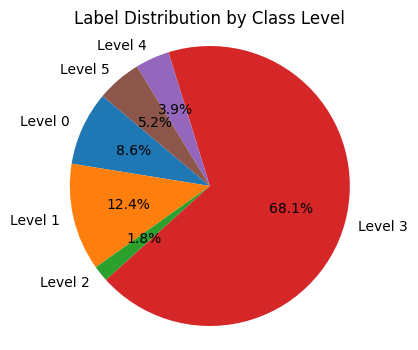

Label Distribution in  Val fold2
level
0     137
1      80
2       4
3    1274
4       9
5      37
Name: count, dtype: int64


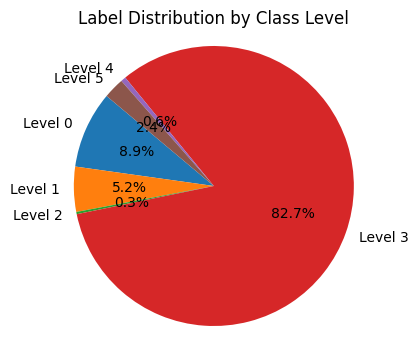

Label Distribution in  Train fold5
level
0     1461
1     2131
2      320
3    12115
4      600
5      962
Name: count, dtype: int64


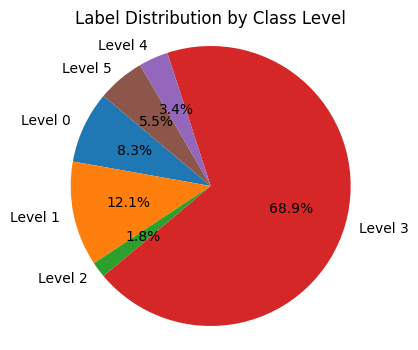

Label Distribution in  Val fold5
level
0     142
1      95
2       6
3    1230
4      20
5      30
Name: count, dtype: int64


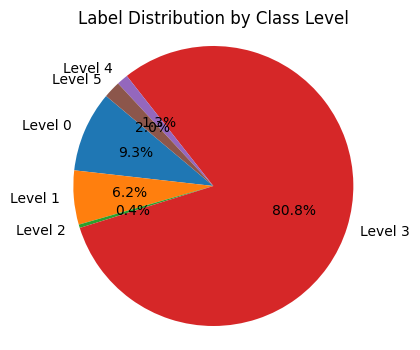

Label Distribution in  Train fold4
level
0     1390
1     2171
2      320
3    12499
4      664
5     1032
Name: count, dtype: int64


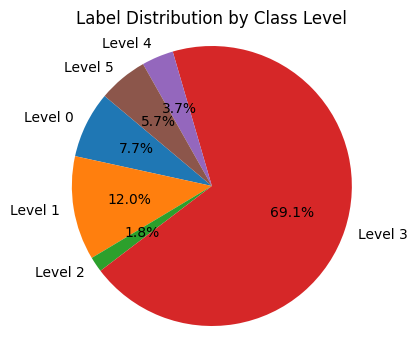

Label Distribution in  Val fold4
level
0     129
1     105
2       6
3    1220
4      18
5      31
Name: count, dtype: int64


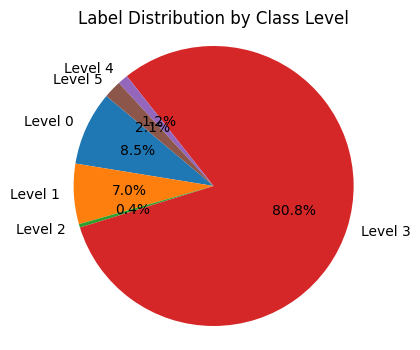

Label Distribution in  Train fold3
level
0     1685
1     2380
2      336
3    13103
4      576
5     1006
Name: count, dtype: int64


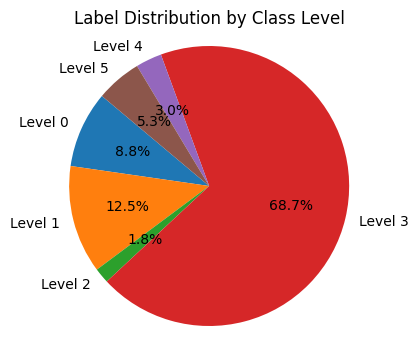

Label Distribution in  Val fold3
level
0     135
1      94
2       5
3    1375
4      21
5      32
Name: count, dtype: int64


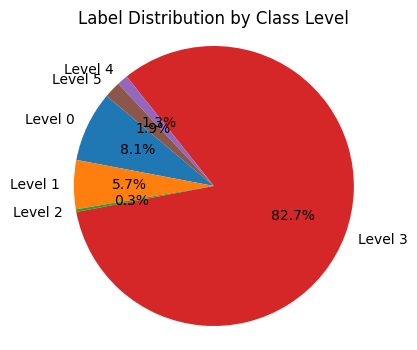

Label Distribution in  Train fold1
level
0     1729
1     2323
2      336
3    12618
4      704
5      968
Name: count, dtype: int64


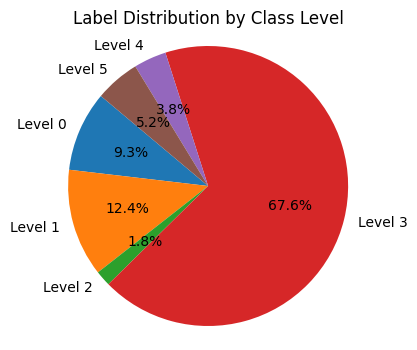

Label Distribution in  Val fold1
level
0     103
1      99
2       5
3    1348
4      13
5      31
Name: count, dtype: int64


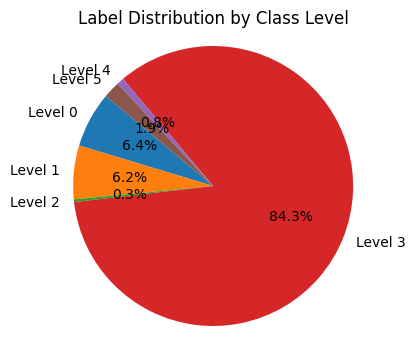

In [38]:
# Set your root directory
root_dir = '/kaggle/working/augmented_dawn'

# Get all folder names in the root directory
folders = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

# Print the folder names
print("Folders found:")
for folder in folders:
    path=f"{root_dir}/{folder}/train/labels"
    print(f"Label Distribution in  Train {folder}")
    label_distribution(path)
    path=f"/{root_dir}/{folder}/val/labels"
    print(f"Label Distribution in  Val {folder}")
    label_distribution(path)

In [39]:
gc.collect()

19240

In [43]:
def file_count(fold):
    folder_path = f'/kaggle/working/augmented_dawn/{fold}/train'
    
    for root, dirs, files in os.walk(folder_path):
        file_count = len(files)
        print(f"{root}: {file_count} file(s)")
        
    folder_path = f'/kaggle/working/augmented_dawn/{fold}/val'
    
    for root, dirs, files in os.walk(folder_path):
        file_count = len(files)
        print(f"{root}: {file_count} file(s)")
        
    folder_path =f'/kaggle/working/augmented_dawn/{fold}/weather'
    
    for root, dirs, files in os.walk(folder_path):
        file_count = len(files)
        print(f"{root}: {file_count} file(s)")

In [44]:
import re
def extract_class_label(filename):
    # Remove extension first
    base = filename.rsplit('.', 1)[0]
    # Remove trailing numeric parts like -563_10, _001, -021
    clean = re.sub(r'[-_](\d+[_-]?)*\d*$', '', base)
    return clean

# Test cases
print(extract_class_label("dust_weather_001.jpg"))     # → dust_weather
print(extract_class_label("rain-021.jpg"))             # → rain
print(extract_class_label("rain_storm-563_10.jpg"))    # → rain_storm
print(extract_class_label("sunny-day_234-12.jpg"))     # → sunny-day

dust_weather
rain
rain_storm
sunny-day


In [45]:
unique_weather=["foggy","rainy","snowy","sand"]

def create_weather_drectory(weather_folder):
    for weather in unique_weather:
        print(f"Weather is: {weather}")
        new_path=os.path.join(weather_folder,weather)
        create_dir(new_path)
        create_dir(os.path.join(new_path,"images"))
        create_dir(os.path.join(new_path,"labels"))

In [46]:
def split_by_weather(source_image_path,dest_folder,weather):
    # print(f"Image Source: {source_image_path}")
    dest_image= os.path.join(os.path.join(dest_folder,weather),"images")
    # print(f"Destination folder: {dest_image}")
    shutil.copy(source_image_path, dest_image)
    # print(f"Copied to: {dest_image}")
    
    source_label_path=source_image_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    # print(f"Label Source: {source_label_path}")
    dest_label = os.path.join(os.path.join(dest_folder,weather),"labels")
    # print(f"Destination folder: {dest_label}")
    shutil.copy(source_label_path,  dest_label)
    # print(f"Copied to: { dest_label}")

In [47]:
# ===== WEATHER-AWARE PREPROCESSING FUNCTIONS =====

import re
def extract_class_label(filename):
    # Remove extension first
    base = filename.rsplit('.', 1)[0]
    # Remove trailing numeric parts like -563_10, _001, -021
    clean = re.sub(r'[-_](\d+[_-]?)*\d*$', '', base)
    return clean

# Test cases
print(extract_class_label("dust_weather_001.jpg"))     # → dust_weather
print(extract_class_label("rain-021.jpg"))             # → rain
print(extract_class_label("rain_storm-563_10.jpg"))    # → rain_storm
print(extract_class_label("sunny-day_234-12.jpg"))     # → sunny-day


def dehaze(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def denoise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def enhance_contrast(image):
    return cv2.convertScaleAbs(image, alpha=1.5, beta=20)


def apply_weather_aware_preprocessing(image, weather_type):
    if weather_type == 'fog':
        return dehaze(image)
    elif weather_type == 'rain':
        return denoise(image)
    elif weather_type == 'snow':
        return enhance_contrast(image)
    else:
        return image  # clear or unknown: no preprocessing


def weather_wise_preprocess(root_dir):
    print(f'{"*"*15} Applying Weather Wise preprocessing {"*"*15}')
    
    # Collect all image paths for progress tracking
    image_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            image_paths.append(os.path.join(dirpath, file))

    # Apply preprocessing with tqdm progress bar
    for source_image_path in tqdm(image_paths, desc="Preprocessing Images"):
        file = os.path.basename(source_image_path)
        weather = extract_class_label(file)
        image = cv2.imread(source_image_path)

        if image is None:
            print(f"❌ Failed to read {source_image_path}")
            continue

        if weather == "rain_storm":
            processed_image = apply_weather_aware_preprocessing(image, "rain")
        elif weather == "snow_storm":
            processed_image = apply_weather_aware_preprocessing(image, "snow")
        elif weather in ["haze", "foggy", "mist"]:
            processed_image = apply_weather_aware_preprocessing(image, "fog")
        else:
            processed_image = apply_weather_aware_preprocessing(image, "sand")

        cv2.imwrite(source_image_path, processed_image)

dust_weather
rain
rain_storm
sunny-day


# Building Model

## Create Data.yaml File

In [48]:
def create_data_yaml(fold,weather=""):
    text = """
        train: /kaggle/working/augmented_dawn/fold_name/train
        val: /kaggle/working/augmented_dawn/fold_name/val
        
        # number of classes
        nc: 6
        
        # class names
        names: ['truck','person','bicycle','car','motorcycle','bus']
        """
    # print(f"previous text: {text}")
    text=text.replace("/fold_name/", f"/{fold}/")

    if(weather!=""):
        text=text.replace("/val", f"/weather/{weather}")
    # print(f"Current text: {text}")
    
    with open(f"{fold}{weather}_data.yaml", 'w') as file:
        file.write(text)

    print(f"Created yaml for {fold} {weather}")

# create_data_yaml("fold1")
create_data_yaml("fold1","rainy")

Created yaml for fold1 rainy


In [49]:
def create_yaml_for_weather(fold):
    create_data_yaml(fold,"foggy")
    create_data_yaml(fold,"rainy")
    create_data_yaml(fold,"snowy")
    create_data_yaml(fold,"sand")

## Hyper Parameter

In [50]:
max_epochs=50
img_size=640 #640/416
batch_size=16 #16/8
optimizer='Adam'
lr_initial=0.001
lr_factor=0.01
early_stop=10
momentum=0.9 
weight_decay=0.0005
warmup_epochs=3 
# Try lowering the confidence threshold during inference
set_conf = 0.1  # Default is 0.25, try values between 0.1-0.3
set_iou = 0.5   # Default is 0.45, try values between 0.4-0.7


## Define Model

In [51]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 194MB/s]


In [52]:
def  define_model():
    
    model = YOLO("yolov8m.pt")
    return model
    

# Train Model

In [53]:
fold_result=[]
weather_result=[]
images_path = '/kaggle/working/dawn/images/'
annotations_path  = '/kaggle/working/dawn/labels/'
path = '/kaggle/working/dawn/'

In [54]:
file_count(fold)

/kaggle/working/augmented_dawn/fold5/train: 0 file(s)
/kaggle/working/augmented_dawn/fold5/train/labels: 2230 file(s)
/kaggle/working/augmented_dawn/fold5/train/images: 2230 file(s)
/kaggle/working/augmented_dawn/fold5/val: 0 file(s)
/kaggle/working/augmented_dawn/fold5/val/labels: 205 file(s)
/kaggle/working/augmented_dawn/fold5/val/images: 205 file(s)


In [55]:
def find_score(metrics,set_conf,set_iou):
    print(f'{"*"*15} Outcome With  conf: {set_conf} & iou: {set_iou}{"*"*15}')
    # print(f"Precision: {metrics.box.p}")
    # print(f"Recall: {metrics.box.r}")
        
    precision = metrics.box.p
    recall = metrics.box.r
        
    f1_score = 2 * (precision * recall) / (precision + recall)
    # print(f"Calculated F1-score: {f1_score}")
        
    inference_time = metrics.speed['inference']
        
    average_precision = np.mean(precision)
    average_recall = np.mean(recall)
    average_f1_score = np.mean(f1_score)
        
    # print(f"Inference time per image: {inference_time:.2f} ms")
    # print(f"\nmAP@0.5 Score: {metrics.box.map50}")
    # print(f"mAP@0.5:0.95 Score: {metrics.box.map}")
    # print(f"\nAverage Precision: {average_precision}")
    # print(f"Average Recall: {average_recall}")
    # print(f"Average F1-score: {average_f1_score}")
    
    fold_result.append((set_conf,set_iou,metrics.box.map50, metrics.box.map, inference_time,
                        average_precision, average_recall,  average_f1_score))
    # Convert to DataFrame
    df = pd.DataFrame(fold_result,
                        columns=["conf","iou","map50", "map", "inference_time",
                        "average_precision","average_recall","average_f1_score"])
    print(df)
    return df

## Final training

In [56]:
def train_and_evaluate(fold,WCA_done="false",run_time=""):
    print(f'{"*"*25} Data Preparation Started for: {fold}_{run_time}{"*"*25}')
    train_path = f'/kaggle/working/augmented_dawn/{fold}/train/'
    test_path = f'/kaggle/working/augmented_dawn/{fold}/val/'
    
    # if(WCA_done=="false"):
    #     print("preprocessing")
    #     weather_wise_preprocess(f'/kaggle/working/augmented_dawn/{fold}/train/images')  
    #     weather_wise_preprocess(f'/kaggle/working/augmented_dawn/{fold}/val/images')
    # else:
    #     print("Already Done")
    
    weather_folder=test_path = f'/kaggle/working/augmented_dawn/{fold}/weather'
    create_dir(weather_folder)
    create_weather_drectory(weather_folder)

    print(f'{"*"*15} Seprating Weather Wise Data for: {fold}{"*"*15}')
    # Set the root directory path
    root_dir =  f'/kaggle/working/augmented_dawn/{fold}/val/images'  
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for file in filenames:
            weather = extract_class_label(file)
            # print(f"Weather is {weather}")
            source_image_path = os.path.join(dirpath, file)
            dest_folder= f'/kaggle/working/augmented_dawn/{fold}/weather'  
            if (weather=="rain_storm"):
                # print(f"This belongs to Rainy Weather")
                split_by_weather(source_image_path, dest_folder,"rainy")
                
            elif (weather=="snow_storm"):
                # print(f"This belongs to Snowy Weather")
                split_by_weather(source_image_path, dest_folder,"snowy")
                
            elif (weather=="haze"or weather=="foggy" or weather=="mist"):
                # print(f"This belongs to Foggy Weather")
                split_by_weather(source_image_path, dest_folder,"foggy")
                
            else:
                # print(f"This belongs to SAND Weather")  # Output: dust_weather
                split_by_weather(source_image_path, dest_folder,"sand")
    
    
    # file_count(fold)
    print(f'{"*"*15} Training Model For: {fold}{"*"*15}')
    
    create_data_yaml(fold)
    model= define_model()
    model_history=model.train(
        data= f"{fold}_data.yaml",
        epochs= max_epochs,
        imgsz= img_size,
        batch = batch_size,
        optimizer= optimizer,
        lr0= lr_initial,
        lrf= lr_factor,
        patience= early_stop,
        momentum= momentum, 
        weight_decay= weight_decay,
        warmup_epochs= warmup_epochs, 
        
        device=0,
        seed=seed,
        project= 'runs',
        name= f'train_{fold}_{run_time}',
        exist_ok= True 
        )
    
    print(f'{"*"*15} Plotting Result for: {fold}{"*"*15}')
    
    output_path = f'/kaggle/working/runs/train_{fold}_{run_time}/'
    def plot(ls, size):
        c=1
        plt.figure(figsize=(15,10))
        for im in ls:
            plt.subplot(size[0],size[1],c)
            im = plt.imread(output_path+im)
            plt.imshow(im)
            c+=1
        plt.show()
        
    plot(['P_curve.png','R_curve.png'], (1,2))
    plot(['F1_curve.png','PR_curve.png'], (1,2))
    plot(['confusion_matrix.png','labels.jpg'], (1,2))
    plot(['results.png'],(1,1))
    
    print(f'{"*"*15} Predicting Outcome  for: {fold}{"*"*15}')
    
    save_project = 'runs'
    save_name = f'custom_preds_{fold}_{run_time}'
    save_dir = f'{save_project}/{save_name}/'
        
    if os.path.exists(save_dir):
        import shutil
        shutil.rmtree(save_dir)
        
    # Choose random images
    plt.figure(figsize=(15, 10))
    imgs = random.sample(os.listdir(images_path), 20)
    c = 1
        
    for img in imgs:
        img_path = os.path.join(images_path, img)
        
        model.predict(
            source=img_path,
            conf=0.4,
            save=True,
            line_width=2,
            show_labels=True,
            project=save_project,
            name=save_name,
            exist_ok=True
         )
            
        im = plt.imread(os.path.join(save_dir, img))
        plt.subplot(4, 5, c)
        plt.axis('off')
        plt.imshow(im)
        c += 1
        
    plt.savefig(f"{fold}_{run_time}_plot_detection.png", dpi=500)

    
    set_conf = 0.1  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.4   # Default is 0.45, try values between 0.4-0.7
    
    model = YOLO(f"/kaggle/working/runs/train_{fold}_{run_time}/weights/best.pt") 
        
    results = model.predict(source=f"/kaggle/working/dawn_5_fold/{fold}/val/images", 
                            save=True, conf=set_conf, iou=set_iou, verbose=True,
                            project='runs',name=f'result_{fold}_{run_time}',exist_ok=True)
    
    print(f'{"*"*15} Evaluating Model for: {fold}{"*"*15}')
    
    test_path = f'/kaggle/working/{fold}_data.yaml'
    
    
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                    project='runs',name=f'validation_{fold}',exist_ok=True) 
    
    df=find_score(metrics,set_conf,set_iou)
    set_conf = 0.1  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.5   # Default is 0.45, try values between 0.4-0.7
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                        project='runs',name=f'validation_{fold}',exist_ok=True) 
    df=find_score(metrics,set_conf,set_iou)
    
    set_conf = 0.1  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.6   # Default is 0.45, try values between 0.4-0.7
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                        project='runs',name=f'validation_{fold}',exist_ok=True) 
        
    df=find_score(metrics,set_conf,set_iou)
    
    set_conf = 0.2  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.4   # Default is 0.45, try values between 0.4-0.7
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                        project='runs',name=f'validation_{fold}',exist_ok=True) 
        
    df=find_score(metrics,set_conf,set_iou)
    set_conf = 0.2  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.5   # Default is 0.45, try values between 0.4-0.7
    
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                        project='runs',name=f'validation_{fold}',exist_ok=True) 
        
    df=find_score(metrics,set_conf,set_iou)
    set_conf = 0.2  # Default is 0.25, try values between 0.1-0.3
    set_iou = 0.6   # Default is 0.45, try values between 0.4-0.7
    metrics = model.val(data=test_path, split='val',  conf=set_conf, iou=set_iou, 
                        project='runs',name=f'validation_{fold}',exist_ok=True) 
        
    df=find_score(metrics,set_conf,set_iou)

    # Find the row with the best metrics.box.map50
    best_row = df.loc[df['map50'].idxmax()]
    # Extract conf and iou values
    best_conf = best_row['conf']
    best_iou = best_row['iou'] 
    print(f"Best conf: {best_conf}, Best iou: {best_iou}")


    print(f'{"*"*15} Weather-Wise Evaluating Model for: {fold}{"*"*15}')
    create_yaml_for_weather(fold)
    for weather in unique_weather:
        data_yaml = f"{fold}{weather}_data.yaml"
        model =YOLO(f"/kaggle/working/runs/train_{fold}_{run_time}/weights/best.pt") 
        metrics = model.val(data=data_yaml, split='val',save=True,conf=best_conf, iou=best_iou,
                            project='runs',name=f'Fold_{fold}_{run_time}_Weather_{weather}',
                            exist_ok=True)
        
        precision=metrics.box.p
        recall = metrics.box.r 
        average_precision = np.mean(precision)
        average_recall = np.mean(recall)
        f1_score = 2 * (average_precision * average_recall) / (average_precision + average_recall)
        
        inference_time = metrics.speed['inference']
        
        weather_result.append((f"{fold}_{run_time}",weather , metrics.box.map50, metrics.box.map, inference_time,
                        average_precision, average_recall,  f1_score))
        
    # Convert to DataFrame
    df = pd.DataFrame(weather_result,
                    columns=["fold","weather","mAP@0.5", "map5095","inference_time(ms)",
                             "precision","recall","f1_score"])
    print(df)
    gc.collect()
    time.sleep(10)

## Fold1

************************* Data Preparation Started for: fold1_frist time*************************
/kaggle/working/augmented_dawn/fold1/weather Folder Created Succesfully
Weather is: foggy
/kaggle/working/augmented_dawn/fold1/weather/foggy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/foggy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/foggy/labels Folder Created Succesfully
Weather is: rainy
/kaggle/working/augmented_dawn/fold1/weather/rainy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/rainy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/rainy/labels Folder Created Succesfully
Weather is: snowy
/kaggle/working/augmented_dawn/fold1/weather/snowy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/snowy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold1/weather/snowy/labels Folder Created Succesfully
Weather is: sand
/kaggle/working

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1934.5±504.0 MB/s, size: 89.4 KB)


train: Scanning /kaggle/working/augmented_dawn/fold1/train/labels... 2334 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2334/2334 [00:01<00:00, 1377.70it/s]


train: New cache created: /kaggle/working/augmented_dawn/fold1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 773.6±671.5 MB/s, size: 91.0 KB)


val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 635.37it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold1/val/labels.cache


Plotting labels to runs/train_fold1_frist time/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train_fold1_frist time
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.79G      1.181      1.198      1.118        184        640: 100%|██████████| 146/146 [01:33<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        205       1599      0.671      0.455       0.47      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.86G      1.143     0.8609      1.108        192        640: 100%|██████████| 146/146 [01:31<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1599        0.5      0.445      0.478      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.93G      1.129     0.8358      1.115        204        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        205       1599      0.526      0.644      0.589      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.89G      1.102     0.7692      1.094        249        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.637      0.503      0.538      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.89G      1.039      0.713      1.069        213        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        205       1599      0.719      0.585        0.6      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.95G      1.017      0.682      1.056        239        640: 100%|██████████| 146/146 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1599      0.767      0.598      0.679       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       8.1G     0.9945     0.6626      1.048        197        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1599      0.788      0.551      0.654      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.08G      0.945     0.6164      1.021        134        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1599      0.756      0.618      0.688      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.79G     0.9225     0.5875      1.013        140        640: 100%|██████████| 146/146 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1599      0.738      0.536      0.661      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.86G     0.9114     0.5812      1.008        138        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1599      0.717      0.652      0.673      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.92G     0.8704     0.5466     0.9953        288        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.714       0.64      0.713      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.12G     0.8884     0.5556     0.9965        217        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1599       0.74      0.694      0.763      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.82G     0.8532     0.5224      0.984        125        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1599      0.836      0.656      0.754       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.88G     0.8432     0.5235     0.9815        192        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1599      0.772      0.702      0.762      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.95G     0.8122      0.499     0.9645        273        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.805       0.63      0.771      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       8.1G     0.7987     0.4835     0.9592        247        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599       0.85      0.697      0.777      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.87G     0.7904     0.4799     0.9576        119        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        205       1599      0.867      0.649      0.738      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.93G     0.7765     0.4691     0.9573        199        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1599      0.885      0.684      0.774      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.06G     0.7573     0.4574     0.9457        206        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1599      0.799      0.686       0.79       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       7.8G     0.7453     0.4498     0.9415        293        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1599      0.798      0.767      0.809      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.87G     0.7339       0.44     0.9369        133        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1599      0.846      0.709        0.8       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.93G     0.7241     0.4335      0.936        146        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        205       1599      0.845      0.665      0.788      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.09G     0.7209     0.4265     0.9293        154        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        205       1599      0.823      0.754      0.799      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.83G     0.7163     0.4262     0.9332        198        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.806      0.759      0.824      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.89G     0.6944     0.4102     0.9248        164        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1599      0.828      0.739      0.812       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.96G     0.7002     0.4171     0.9242        245        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1599      0.848       0.73      0.828      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.86G     0.6791     0.4059     0.9184        235        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599      0.825      0.766      0.824      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.87G     0.6791     0.4035     0.9143        176        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        205       1599      0.791      0.768      0.826      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.94G     0.6643     0.3943      0.916        125        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        205       1599      0.833      0.691      0.797       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.9G     0.6545     0.3846     0.9062        320        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        205       1599      0.823      0.699      0.795      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.91G     0.6422     0.3786     0.9056        228        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        205       1599      0.866      0.776      0.836      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.97G     0.6459      0.377     0.9051        177        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.819      0.812      0.828      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.29G      0.626     0.3655     0.8998        137        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        205       1599      0.879      0.748      0.831      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.81G     0.6162     0.3605     0.8977        182        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599      0.897      0.733      0.847      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.86G     0.6152     0.3604     0.8968        175        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.833      0.747      0.815      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.93G     0.6106     0.3549     0.8966        159        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599      0.858       0.75      0.828      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       8.3G     0.6054     0.3544     0.8919        136        640: 100%|██████████| 146/146 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1599      0.885      0.731       0.83      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.06G     0.5828     0.3418     0.8868        131        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599      0.836      0.778      0.834      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.05G     0.5786     0.3354      0.882        160        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        205       1599      0.899       0.79      0.847      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.05G     0.5728     0.3324     0.8813        158        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        205       1599      0.877      0.805       0.85      0.594


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.05G     0.5564     0.3069     0.8732         73        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1599      0.829      0.794      0.838      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.04G     0.5461     0.2997     0.8704        101        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1599       0.89      0.706      0.823      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.02G     0.5359     0.2958     0.8623         86        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        205       1599       0.81      0.827      0.846      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.04G     0.5264     0.2891     0.8607         65        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1599      0.776      0.805      0.829       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.04G     0.5052     0.2775     0.8516        102        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        205       1599      0.872        0.8       0.85      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.05G     0.5028     0.2752     0.8539        121        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1599      0.802      0.774      0.826      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.04G     0.4901     0.2686     0.8499        129        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        205       1599      0.903      0.709      0.845      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.05G     0.4826     0.2655     0.8476        116        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        205       1599      0.784      0.802      0.842      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.84G     0.4718       0.26     0.8432        140        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1599      0.875       0.71      0.834      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.9G     0.4627     0.2573     0.8416         58        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        205       1599      0.767      0.808      0.842      0.603



50 epochs completed in 1.313 hours.
Optimizer stripped from runs/train_fold1_frist time/weights/last.pt, 52.0MB
Optimizer stripped from runs/train_fold1_frist time/weights/best.pt, 52.0MB

Validating runs/train_fold1_frist time/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.835      0.805      0.844      0.608
                 truck         62        103      0.859       0.67      0.827      0.576
                person         41         99      0.785      0.828      0.853      0.571
               bicycle          4          5      0.806          1      0.962      0.721
                   car        202       1348      0.908      0.851      0.916      0.648
            motorcycle          9         13      0.805      0.769      0.775      0.563
                   bus         21         31      0.847      0.714      0.733       0.57
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/train_fold1_frist time
*************** Plotting Result for: fold1***************


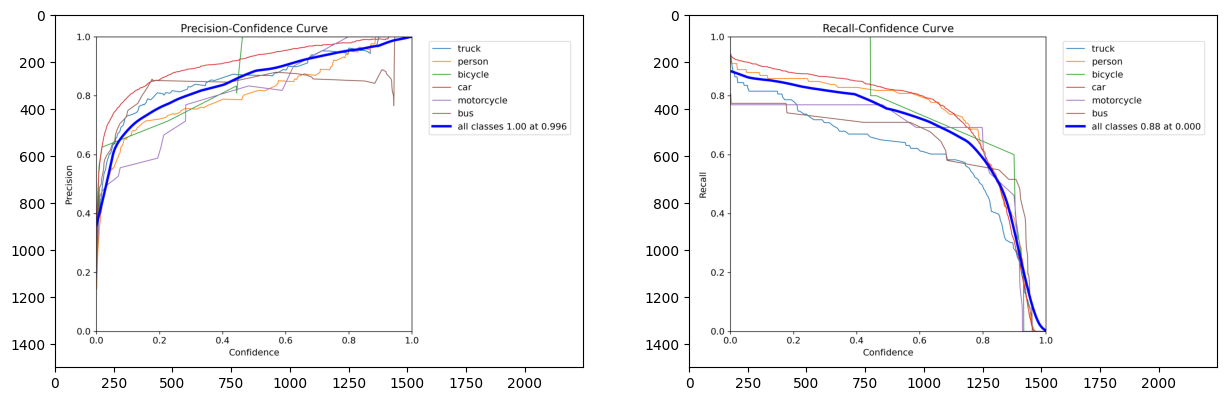

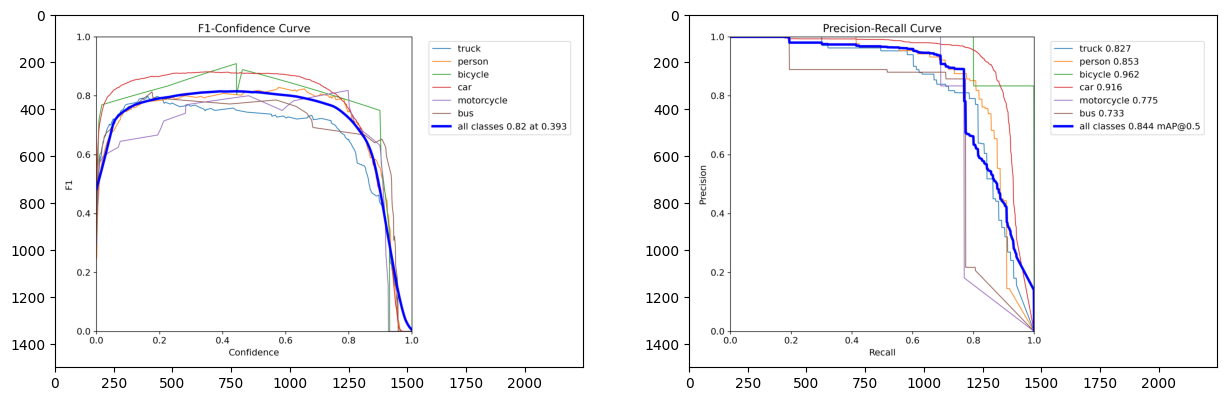

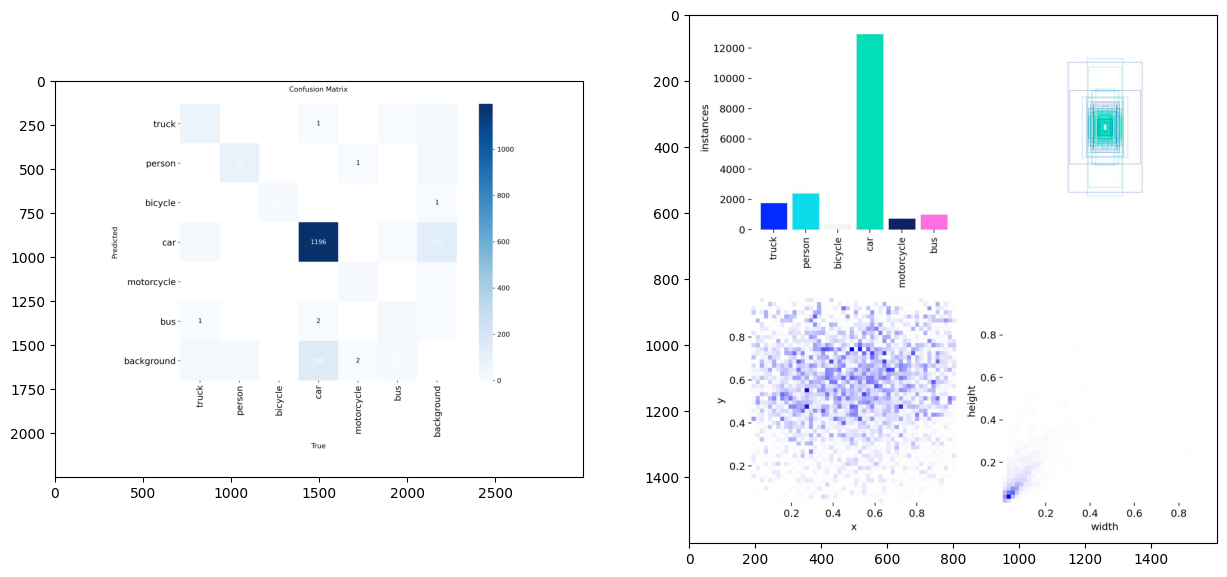

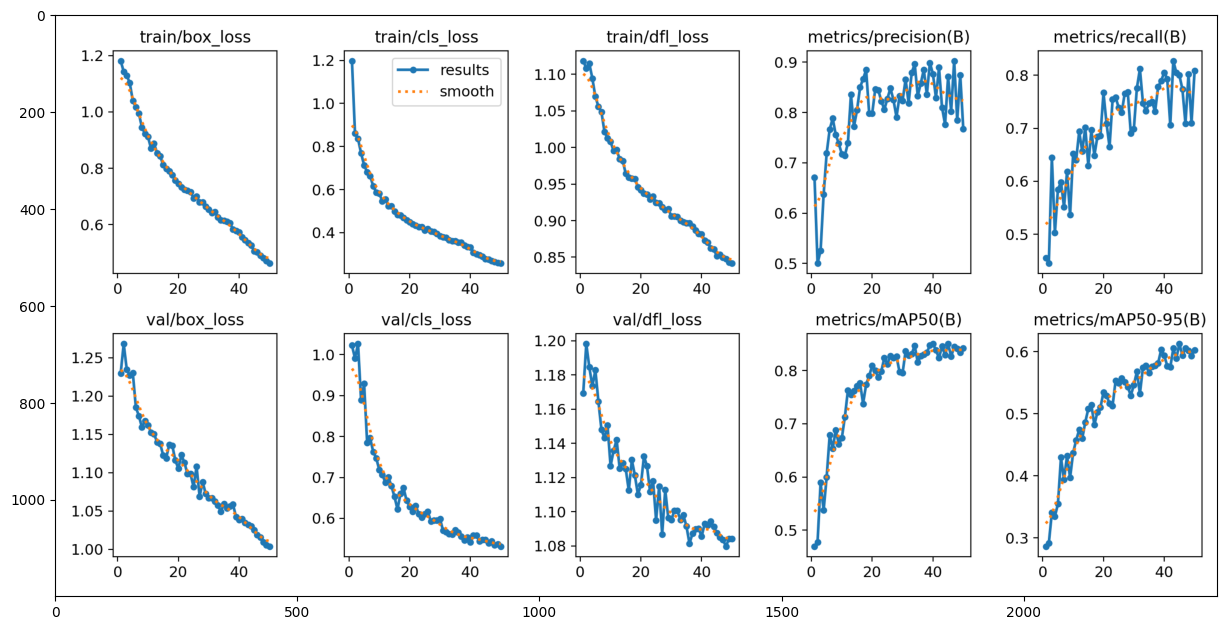

*************** Predicting Outcome  for: fold1***************

image 1/1 /kaggle/working/dawn/images/foggy-051.jpg: 384x640 1 truck, 1 car, 41.0ms
Speed: 1.9ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold1_frist time

image 1/1 /kaggle/working/dawn/images/mist-152.jpg: 384x640 4 cars, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold1_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-009.jpg: 448x640 1 person, 6 cars, 42.9ms
Speed: 3.4ms preprocess, 42.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/custom_preds_fold1_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-149.jpg: 352x640 2 persons, 4 cars, 42.8ms
Speed: 1.8ms preprocess, 42.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/custom_preds_fold1_frist t

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.845      0.806       0.87      0.651
                 truck         62        103      0.861       0.68      0.838      0.619
                person         41         99      0.833      0.828      0.876      0.615
               bicycle          4          5      0.806          1      0.962      0.747
                   car        202       1348       0.92      0.848      0.922      0.686
            motorcycle          9         13      0.803      0.769      0.828      0.606
                   bus         21         31      0.847      0.713      0.793      0.634
Speed: 1.0ms preprocess, 8.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.1 & iou: 0.4***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512            0.84489   

   average_recall  average_f1_score  
0        

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.845      0.807       0.87      0.651
                 truck         62        103      0.861       0.68      0.838      0.617
                person         41         99      0.833      0.828      0.876      0.615
               bicycle          4          5      0.806          1      0.962      0.747
                   car        202       1348       0.92      0.851      0.924      0.688
            motorcycle          9         13      0.803      0.769      0.828      0.606
                   bus         21         31      0.847      0.713      0.793      0.634
Speed: 1.0ms preprocess, 7.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.1 & iou: 0.5***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.841      0.807       0.87      0.651
                 truck         62        103      0.861       0.68      0.838      0.617
                person         41         99      0.809      0.828      0.874      0.616
               bicycle          4          5      0.807          1      0.962      0.747
                   car        202       1348      0.917      0.851      0.923      0.687
            motorcycle          9         13      0.804      0.769      0.828      0.606
                   bus         21         31      0.847      0.713      0.793      0.634
Speed: 0.9ms preprocess, 7.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.1 & iou: 0.6***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.845      0.806      0.864      0.652
                 truck         62        103      0.861       0.68      0.824      0.618
                person         41         99      0.833      0.828      0.877      0.621
               bicycle          4          5      0.807          1      0.962      0.747
                   car        202       1348      0.919      0.847      0.916      0.688
            motorcycle          9         13      0.804      0.769      0.833      0.612
                   bus         21         31      0.846       0.71      0.773      0.628
Speed: 1.0ms preprocess, 7.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.2 & iou: 0.4***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.845      0.806      0.864      0.652
                 truck         62        103      0.861       0.68      0.824      0.616
                person         41         99      0.833      0.828      0.877      0.621
               bicycle          4          5      0.807          1      0.962      0.747
                   car        202       1348       0.92      0.851      0.917      0.689
            motorcycle          9         13      0.804      0.769      0.833      0.612
                   bus         21         31      0.846       0.71      0.773      0.628
Speed: 0.8ms preprocess, 7.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.2 & iou: 0.5***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold1/val/labels.cache... 205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1599      0.853      0.802      0.864      0.652
                 truck         62        103      0.874      0.672      0.824      0.616
                person         41         99      0.823      0.818      0.874      0.621
               bicycle          4          5      0.832          1      0.962      0.747
                   car        202       1348      0.923      0.841      0.917      0.688
            motorcycle          9         13      0.819      0.769      0.833      0.612
                   bus         21         31      0.849       0.71      0.773      0.628
Speed: 0.9ms preprocess, 7.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/validation_fold1
*************** Outcome With  conf: 0.2 & iou: 0.6***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold1/weather/foggy/labels... 67 images, 1 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 1375.09it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold1/weather/foggy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         67        469      0.864      0.795      0.887      0.662
                 truck         18         37      0.796      0.633      0.793      0.508
                person         14         35      0.813      0.886      0.916      0.673
               bicycle          3          4          1      0.975      0.995      0.765
                   car         65        370      0.946      0.847      0.929      0.707
            motorcycle          5          7      0.728      0.857      0.899      0.698
                   bus         10         16      0.902      0.573      0.788      0.623
Speed: 3.2ms preprocess, 8.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/Fold_fold1_frist time_Weather_foggy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1767.3±945

val: Scanning /kaggle/working/augmented_dawn/fold1/weather/rainy/labels... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<00:00, 1401.91it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold1/weather/rainy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         42        280      0.881      0.651      0.791      0.599
                 truck         12         19      0.823      0.489      0.744      0.576
                person          5          6      0.802      0.833       0.88      0.688
                   car         42        253      0.966      0.783      0.918      0.636
                   bus          2          2      0.935        0.5      0.622      0.498
Speed: 3.6ms preprocess, 12.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/Fold_fold1_frist time_Weather_rainy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2259.0±556.8 MB/s, size: 127.3 KB)


val: Scanning /kaggle/working/augmented_dawn/fold1/weather/snowy/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 1343.50it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold1/weather/snowy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         34        423      0.927      0.891      0.941      0.693
                 truck          9         12      0.916      0.912       0.94      0.817
                person          9         32      0.881      0.812       0.91      0.569
                   car         34        373       0.91       0.84      0.921      0.661
                   bus          3          6          1          1      0.995      0.723
Speed: 5.0ms preprocess, 17.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/Fold_fold1_frist time_Weather_snowy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1967.3±509.2 MB/s, size: 118.2 KB)


val: Scanning /kaggle/working/augmented_dawn/fold1/weather/sand/labels... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 1243.20it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold1/weather/sand/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         62        427      0.873      0.816      0.874      0.697
                 truck         23         35      0.962      0.729      0.893      0.675
                person         13         26      0.767      0.769      0.824      0.603
               bicycle          1          1          1          1      0.995      0.895
                   car         61        352      0.937      0.875      0.935      0.734
            motorcycle          4          6      0.904      0.667        0.8      0.572
                   bus          6          7      0.667      0.857      0.796        0.7
Speed: 3.2ms preprocess, 10.8ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/Fold_fold1_frist time_Weather_sand
               fold weather   mAP@0.5   map5095  inference_time(ms)  \
0  fold1_frist time   foggy  0.886637  0.662417            8.323134   
1  fold1_frist time   rainy  0.791193  0.599470           12.221686   
2  fold1_frist time   sn

In [57]:
train_and_evaluate("fold1","false","frist time")

## Fold2

************************* Data Preparation Started for: fold2_frist time*************************
/kaggle/working/augmented_dawn/fold2/weather Folder Created Succesfully
Weather is: foggy
/kaggle/working/augmented_dawn/fold2/weather/foggy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/foggy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/foggy/labels Folder Created Succesfully
Weather is: rainy
/kaggle/working/augmented_dawn/fold2/weather/rainy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/rainy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/rainy/labels Folder Created Succesfully
Weather is: snowy
/kaggle/working/augmented_dawn/fold2/weather/snowy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/snowy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold2/weather/snowy/labels Folder Created Succesfully
Weather is: sand
/kaggle/working

train: Scanning /kaggle/working/augmented_dawn/fold2/train/labels... 2322 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:01<00:00, 1378.02it/s]


train: New cache created: /kaggle/working/augmented_dawn/fold2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 346.8±150.9 MB/s, size: 197.8 KB)


val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 477.64it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold2/val/labels.cache


Plotting labels to runs/train_fold2_frist time/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train_fold2_frist time
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.73G      1.186      1.178      1.118         16        640: 100%|██████████| 146/146 [01:32<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1541      0.693      0.546      0.567      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       7.8G      1.137     0.8682      1.109          9        640: 100%|██████████| 146/146 [01:31<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1541      0.513      0.469      0.501      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.87G      1.132     0.8351      1.107         33        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        205       1541      0.693      0.433      0.529       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.93G      1.094      0.774      1.086         14        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541      0.466      0.485      0.504      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.23G      1.053     0.7241      1.072          4        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1541      0.511      0.435      0.494      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.12G      1.024     0.6833      1.057         18        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541      0.652      0.513      0.603      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.86G     0.9932     0.6511      1.045         37        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1541      0.676      0.552      0.656      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.91G     0.9617     0.6156      1.034         33        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1541      0.585      0.563      0.606      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.99G      0.933     0.5865      1.014         37        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541      0.703      0.515      0.596       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.91G     0.9116     0.5771      1.008          4        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541      0.589      0.501      0.598      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.94G     0.8852     0.5554      1.003         13        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1541       0.71      0.606      0.637      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.88G     0.8739     0.5469     0.9892         10        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1541      0.674      0.618      0.684      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.95G     0.8607      0.528     0.9848         16        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1541      0.676       0.56      0.675      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.85G     0.8376     0.5152     0.9773         57        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541      0.636      0.729      0.737      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.92G     0.8254     0.5062     0.9763         77        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1541      0.668      0.635      0.665      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.98G     0.8083     0.4968     0.9677          2        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1541      0.718      0.597      0.659      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.91G      0.788     0.4791     0.9582         25        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1541      0.657      0.614      0.671      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.93G     0.7801     0.4727     0.9566         21        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1541      0.754      0.618      0.712      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       7.9G     0.7644     0.4622     0.9487          9        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541      0.742      0.633      0.719      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.95G     0.7522     0.4579     0.9401         34        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1541      0.682       0.64      0.697      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.12G     0.7432     0.4484     0.9369         13        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541       0.77       0.64      0.712      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.09G     0.7353     0.4423     0.9391         21        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1541      0.772      0.608      0.665      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       8.1G     0.7026     0.4158     0.9234         12        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541      0.736      0.601      0.687      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.08G     0.7045     0.4222     0.9251         55        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1541      0.769      0.618      0.743      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       8.1G     0.6949     0.4118     0.9249         18        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541       0.76      0.633      0.714      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.84G     0.7038     0.4181     0.9241          8        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        205       1541      0.732      0.623        0.7      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.92G     0.6936     0.4069     0.9183         41        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        205       1541      0.761      0.675      0.706       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.98G     0.6669     0.3943     0.9132          9        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1541      0.614       0.68      0.705      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.92G     0.6754     0.3962     0.9138          7        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541      0.682      0.643      0.676      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.95G     0.6622     0.3874     0.9094         40        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1541      0.703      0.642      0.716       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       8.1G      0.645     0.3794     0.9031         29        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1541      0.754      0.627       0.67      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.09G      0.636     0.3734     0.9006         14        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1541      0.735      0.626      0.712      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.89G      0.626     0.3705     0.8993          4        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1541      0.785      0.591      0.699      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.95G     0.6262     0.3636     0.9024          6        640: 100%|██████████| 146/146 [01:30<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1541      0.762      0.616       0.68      0.465
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 24, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



34 epochs completed in 0.890 hours.
Optimizer stripped from runs/train_fold2_frist time/weights/last.pt, 52.0MB
Optimizer stripped from runs/train_fold2_frist time/weights/best.pt, 52.0MB

Validating runs/train_fold2_frist time/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541       0.77      0.619      0.743      0.471
                 truck         61        137      0.736      0.692      0.732      0.474
                person         42         80      0.915      0.675      0.833      0.499
               bicycle          4          4      0.445        0.5      0.711      0.476
                   car        202       1274      0.906      0.826      0.915       0.64
            motorcycle          9          9      0.974      0.778      0.866      0.457
                   bus         21         37      0.645      0.245      0.404       0.28
Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/train_fold2_frist time
*************** Plotting Result for: fold2***************


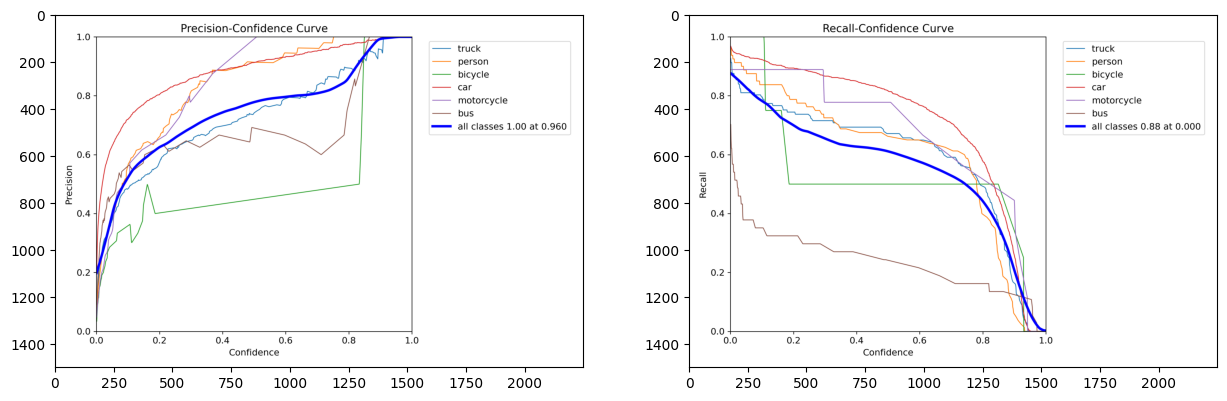

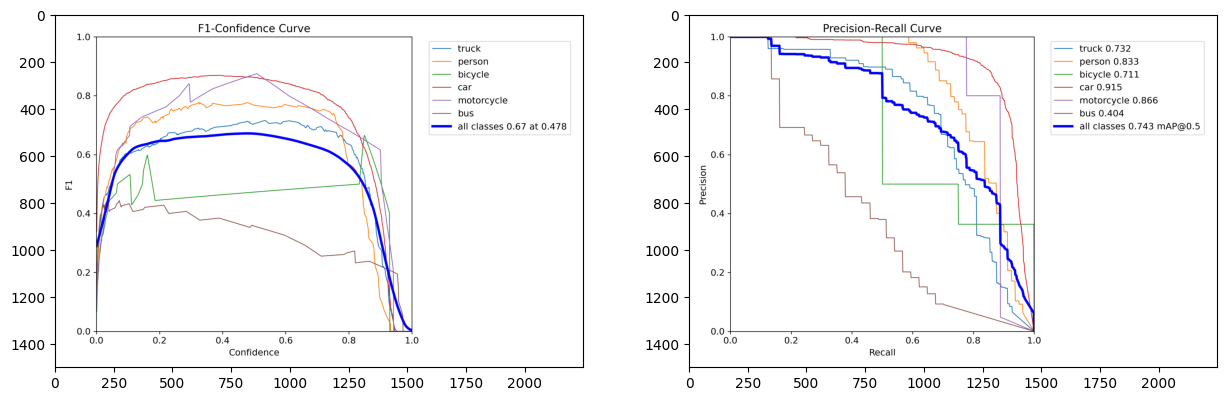

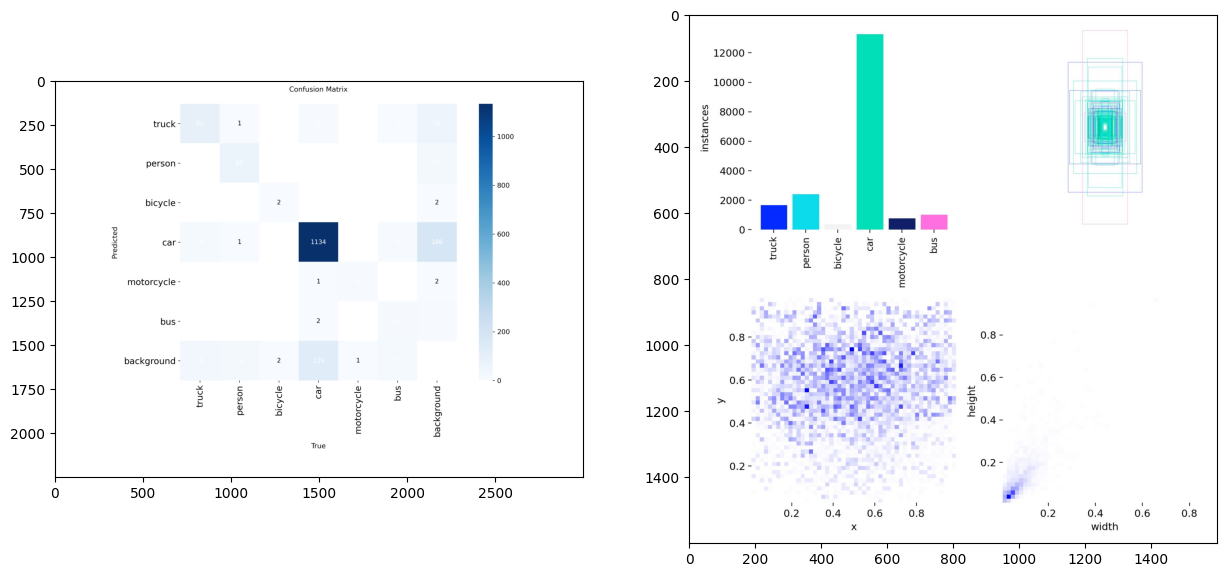

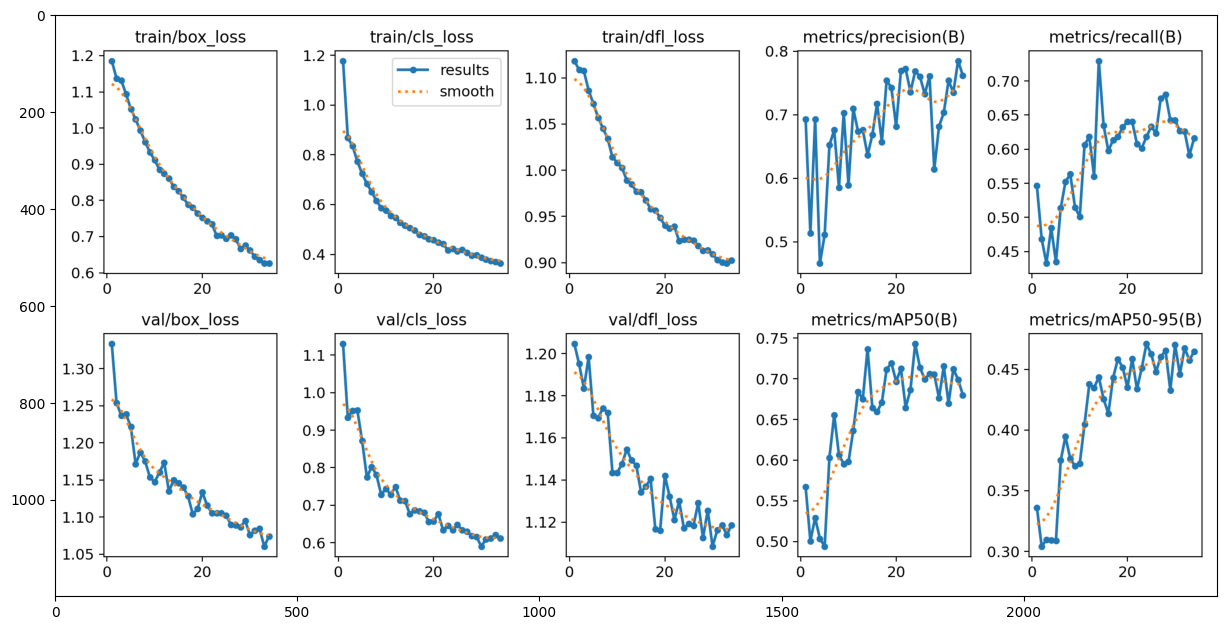

*************** Predicting Outcome  for: fold2***************

image 1/1 /kaggle/working/dawn/images/foggy-051.jpg: 384x640 2 cars, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold2_frist time

image 1/1 /kaggle/working/dawn/images/mist-152.jpg: 384x640 5 cars, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold2_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-009.jpg: 448x640 9 cars, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/custom_preds_fold2_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-149.jpg: 352x640 2 persons, 4 cars, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/custom_preds_fold2_frist time

image 1/1 /ka

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.776      0.616      0.755      0.514
                 truck         61        137      0.742      0.693      0.751      0.515
                person         42         80      0.905      0.662      0.824      0.539
               bicycle          4          4      0.445        0.5      0.731      0.516
                   car        202       1274      0.911      0.821      0.918      0.676
            motorcycle          9          9      0.977      0.778      0.828      0.483
                   bus         21         37      0.678      0.243      0.475      0.353
Speed: 1.2ms preprocess, 8.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.1 & iou: 0.4***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.776      0.617      0.755      0.514
                 truck         61        137      0.742      0.693       0.75      0.513
                person         42         80      0.905      0.662      0.827       0.54
               bicycle          4          4      0.445        0.5      0.731      0.516
                   car        202       1274       0.91      0.823      0.919      0.676
            motorcycle          9          9      0.977      0.778      0.828      0.483
                   bus         21         37      0.678      0.243      0.475      0.353
Speed: 0.9ms preprocess, 7.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.1 & iou: 0.5***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.778      0.616      0.755      0.513
                 truck         61        137      0.737      0.693       0.75      0.512
                person         42         80      0.907      0.662      0.826      0.539
               bicycle          4          4      0.446        0.5      0.731      0.516
                   car        202       1274      0.913      0.822      0.918      0.675
            motorcycle          9          9      0.982      0.778      0.828      0.483
                   bus         21         37      0.683      0.243      0.475      0.353
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.1 & iou: 0.6***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.781      0.617      0.737      0.517
                 truck         61        137      0.739      0.693      0.746      0.517
                person         42         80      0.901      0.662      0.819      0.546
               bicycle          4          4        0.5        0.5      0.622      0.498
                   car        202       1274      0.908      0.825      0.911      0.679
            motorcycle          9          9      0.968      0.778      0.841      0.495
                   bus         21         37      0.669      0.243      0.481      0.367
Speed: 1.0ms preprocess, 7.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.2 & iou: 0.4***************
   conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1   0.1  0.5  0.870157  0.651215        7.889638

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.781      0.617      0.737      0.517
                 truck         61        137      0.739      0.693      0.745      0.517
                person         42         80      0.901      0.662      0.818      0.545
               bicycle          4          4        0.5        0.5      0.622      0.498
                   car        202       1274      0.908      0.827      0.912      0.679
            motorcycle          9          9      0.968      0.778      0.841      0.495
                   bus         21         37      0.669      0.243      0.481      0.367
Speed: 1.0ms preprocess, 7.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.2 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold2/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1541      0.782      0.617      0.736      0.516
                 truck         61        137      0.729      0.693      0.744      0.515
                person         42         80      0.904      0.662      0.817      0.544
               bicycle          4          4        0.5        0.5      0.622      0.498
                   car        202       1274      0.907      0.823      0.912      0.679
            motorcycle          9          9      0.974      0.778      0.841      0.495
                   bus         21         37      0.675      0.243      0.481      0.367
Speed: 0.9ms preprocess, 7.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/validation_fold2
*************** Outcome With  conf: 0.2 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold2/weather/foggy/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1253.17it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold2/weather/foggy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         55        269      0.889      0.781       0.86      0.552
                 truck         13         22      0.908      0.682      0.766      0.504
                person          7         11          1      0.904      0.971      0.529
               bicycle          1          1      0.745          1      0.995      0.796
                   car         55        218       0.93      0.862       0.95      0.722
            motorcycle          2          2          1      0.971      0.995      0.398
                   bus          7         15      0.751      0.267      0.485      0.365
Speed: 5.3ms preprocess, 8.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/Fold_fold2_frist time_Weather_foggy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 980.0±315.

val: Scanning /kaggle/working/augmented_dawn/fold2/weather/rainy/labels... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<00:00, 1293.60it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold2/weather/rainy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         39        372      0.838      0.652      0.753      0.521
                 truck         16         54      0.789       0.76      0.842      0.584
                person          2          4      0.624        0.5      0.463       0.26
                   car         38        312      0.938      0.849      0.956      0.715
                   bus          2          2          1        0.5       0.75      0.525
Speed: 3.0ms preprocess, 13.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/Fold_fold2_frist time_Weather_rainy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1607.8±734.7 MB/s, size: 551.0 KB)


val: Scanning /kaggle/working/augmented_dawn/fold2/weather/snowy/labels... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<00:00, 1371.01it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold2/weather/snowy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         42        462      0.848      0.754      0.855      0.605
                 truck         11         23      0.684      0.565      0.616      0.449
                person         16         35      0.914      0.714       0.86      0.616
               bicycle          1          1      0.736          1      0.995      0.796
                   car         42        398      0.914      0.743      0.884      0.617
            motorcycle          1          1      0.843          1      0.995      0.497
                   bus          4          4          1      0.499       0.78      0.655
Speed: 3.9ms preprocess, 12.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/Fold_fold2_frist time_Weather_snowy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 761.8±287

val: Scanning /kaggle/working/augmented_dawn/fold2/weather/sand/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 1365.96it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold2/weather/sand/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         69        438      0.568      0.728      0.709      0.462
                 truck         21         38      0.509      0.763      0.685      0.463
                person         17         30      0.522        0.8      0.757      0.492
               bicycle          2          2      0.667          1      0.828      0.356
                   car         67        346      0.764      0.887      0.902      0.681
            motorcycle          6          6        0.5      0.667      0.749      0.507
                   bus          8         16      0.444       0.25      0.334      0.272
Speed: 3.6ms preprocess, 9.3ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/Fold_fold2_frist time_Weather_sand
               fold weather   mAP@0.5   map5095  inference_time(ms)  \
0  fold1_frist time   foggy  0.886637  0.662417            8.323134   
1  fold1_frist time   rainy  0.791193  0.599470           12.221686   
2  fold1_frist time   sno

In [58]:
train_and_evaluate("fold2","false","frist time")

## Fold3

************************* Data Preparation Started for: fold3_frist time*************************
/kaggle/working/augmented_dawn/fold3/weather Folder Created Succesfully
Weather is: foggy
/kaggle/working/augmented_dawn/fold3/weather/foggy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/foggy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/foggy/labels Folder Created Succesfully
Weather is: rainy
/kaggle/working/augmented_dawn/fold3/weather/rainy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/rainy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/rainy/labels Folder Created Succesfully
Weather is: snowy
/kaggle/working/augmented_dawn/fold3/weather/snowy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/snowy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold3/weather/snowy/labels Folder Created Succesfully
Weather is: sand
/kaggle/working

train: Scanning /kaggle/working/augmented_dawn/fold3/train/labels... 2299 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2299/2299 [00:01<00:00, 1392.05it/s]

train: New cache created: /kaggle/working/augmented_dawn/fold3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 429.5±119.1 MB/s, size: 312.0 KB)


val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<00:00, 992.98it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold3/val/labels.cache


Plotting labels to runs/train_fold3_frist time/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train_fold3_frist time
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.92G      1.182      1.189      1.122        205        640: 100%|██████████| 144/144 [01:31<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        206       1662      0.754      0.515      0.608      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.98G      1.149     0.8823      1.113        159        640: 100%|██████████| 144/144 [01:30<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        206       1662      0.552      0.453      0.496      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       7.8G      1.123     0.8235      1.106        175        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        206       1662      0.596      0.535      0.555      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.84G      1.111     0.7944      1.101        160        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        206       1662      0.665      0.526      0.555      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       7.9G      1.069     0.7459      1.079        106        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        206       1662      0.772      0.472      0.576      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.97G      1.032     0.6964      1.061        171        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        206       1662      0.698      0.561      0.608      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.79G      1.004     0.6595      1.049        201        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        206       1662      0.755      0.567      0.645      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.79G     0.9561     0.6157      1.031        323        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        206       1662      0.579      0.667      0.632      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.86G     0.9334     0.5996      1.014        175        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.727      0.632      0.662      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.93G     0.9187     0.5777      1.008        237        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        206       1662      0.797      0.618      0.666        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.06G     0.8973     0.5625      1.002         83        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        206       1662      0.788      0.604      0.671      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.74G     0.8895     0.5564     0.9965        236        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        206       1662      0.676       0.63      0.671      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.78G     0.8764      0.546     0.9912        133        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        206       1662      0.726      0.621      0.666      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.85G     0.8563     0.5304      0.985        215        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        206       1662      0.807      0.638      0.692      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.91G     0.8236     0.5021     0.9716        151        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        206       1662      0.738      0.681        0.7      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.98G      0.822     0.4949     0.9695        185        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        206       1662      0.855       0.64      0.741      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.05G     0.8088     0.4834     0.9641        102        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        206       1662      0.727      0.721      0.718      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.79G     0.7875     0.4789     0.9591        157        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        206       1662      0.777      0.646      0.712      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.84G     0.7682     0.4615     0.9489         65        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        206       1662      0.843      0.713      0.761      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.91G     0.7602     0.4584     0.9446        164        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        206       1662      0.712      0.736      0.715      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.97G     0.7455     0.4469     0.9381        171        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.811      0.713      0.737      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.82G     0.7402     0.4394     0.9392        127        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        206       1662      0.804      0.667      0.723      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.82G      0.716      0.424     0.9296        185        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        206       1662      0.838      0.695      0.758      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.89G     0.7226     0.4289      0.936        149        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        206       1662      0.841      0.684      0.744      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.96G      0.716     0.4223     0.9296        210        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        206       1662      0.851      0.686      0.743      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.04G     0.6898     0.4107     0.9184        243        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        206       1662      0.867      0.646      0.737      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.75G     0.6873     0.4076     0.9255        202        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        206       1662      0.855      0.714      0.761      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.81G     0.6803     0.4009     0.9165        266        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.846      0.658      0.739      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.88G     0.6765     0.3952     0.9187        128        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.861      0.686      0.742      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.95G     0.6608     0.3881     0.9113        200        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        206       1662      0.856      0.728      0.775      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.84G     0.6441     0.3738     0.9032        118        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        206       1662      0.856      0.724      0.773      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.85G     0.6483     0.3789     0.9078        134        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        206       1662      0.727      0.748      0.739      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.92G     0.6259     0.3682     0.8995        207        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        206       1662      0.872      0.621      0.721      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.77G     0.6292     0.3665     0.8987        205        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        206       1662      0.869      0.679      0.757       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.8G     0.6148     0.3574     0.8949        124        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.771      0.769      0.764      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.87G     0.6091     0.3509     0.8938        201        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        206       1662      0.774      0.738      0.766      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.93G     0.5955      0.347     0.8932        195        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        206       1662      0.808      0.728      0.767      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.79G     0.5901     0.3435     0.8863        144        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        206       1662      0.798      0.653       0.69       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.8G     0.5878      0.338     0.8834        144        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        206       1662      0.852      0.678      0.766      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.87G     0.5711     0.3333     0.8819        140        640: 100%|██████████| 144/144 [01:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.863      0.673      0.755      0.502


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.94G      0.561     0.3072     0.8739         50        640: 100%|██████████| 144/144 [01:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662       0.85       0.64      0.714      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.05G     0.5463     0.2975     0.8672         57        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        206       1662      0.798      0.753      0.768      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.73G      0.535     0.2935     0.8615         47        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        206       1662      0.694      0.732      0.751      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.79G     0.5279     0.2902      0.863        103        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        206       1662      0.749       0.71      0.744      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.85G     0.5138     0.2815     0.8558         76        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        206       1662       0.86       0.74       0.79      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.92G     0.5007      0.274     0.8493        109        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        206       1662      0.834      0.751       0.79      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.81G     0.4877     0.2693     0.8481        113        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        206       1662      0.849      0.755      0.801      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.81G     0.4819     0.2652     0.8453         68        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        206       1662      0.861      0.763      0.797       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.88G     0.4702     0.2593     0.8421         32        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        206       1662      0.864      0.745      0.803      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.94G     0.4702     0.2585     0.8434        110        640: 100%|██████████| 144/144 [01:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        206       1662      0.841      0.767        0.8      0.532



50 epochs completed in 1.297 hours.
Optimizer stripped from runs/train_fold3_frist time/weights/last.pt, 52.0MB
Optimizer stripped from runs/train_fold3_frist time/weights/best.pt, 52.0MB

Validating runs/train_fold3_frist time/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.859       0.74      0.789      0.532
                 truck         61        135      0.764      0.743      0.749      0.517
                person         42         94      0.833      0.691      0.782      0.524
               bicycle          4          5      0.993        0.6      0.636      0.259
                   car        201       1375      0.905      0.858      0.917      0.663
            motorcycle         10         21      0.835      0.857      0.921      0.624
                   bus         21         32      0.828      0.688      0.732      0.607
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/train_fold3_frist time
*************** Plotting Result for: fold3***************


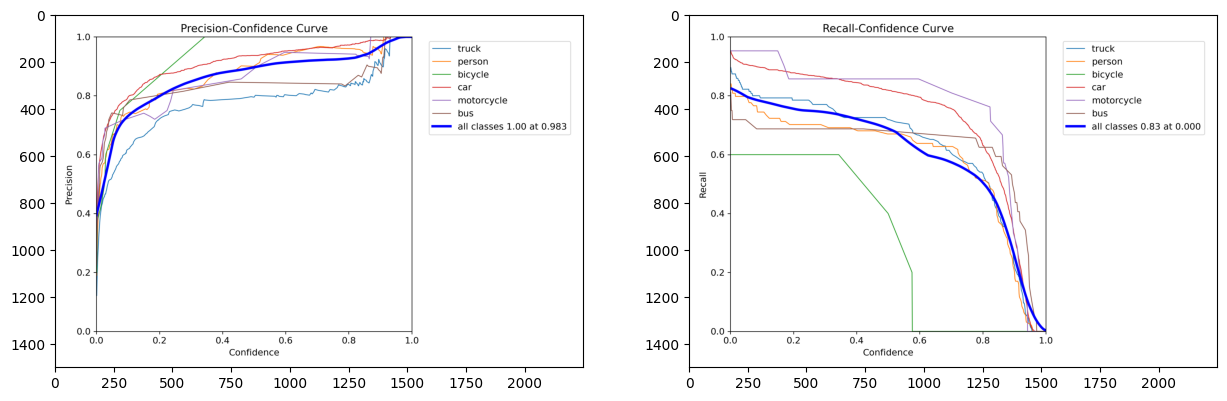

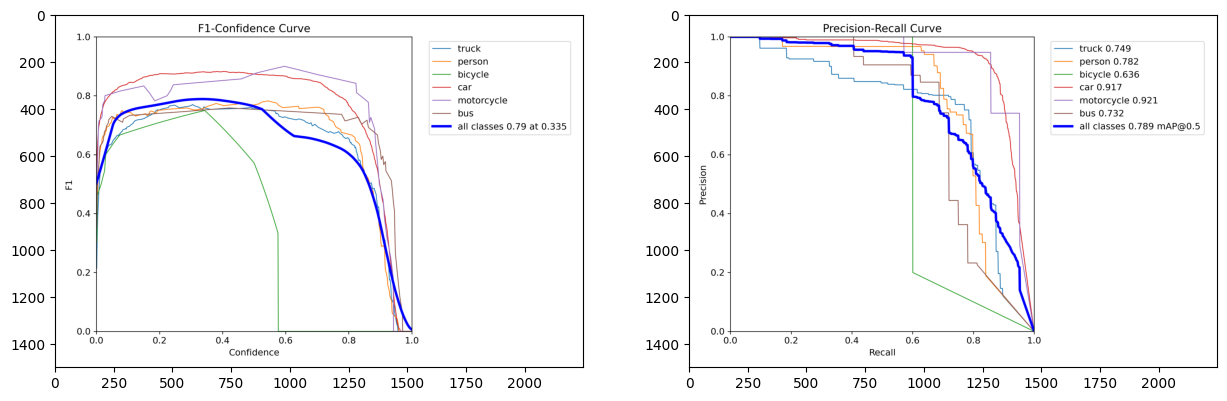

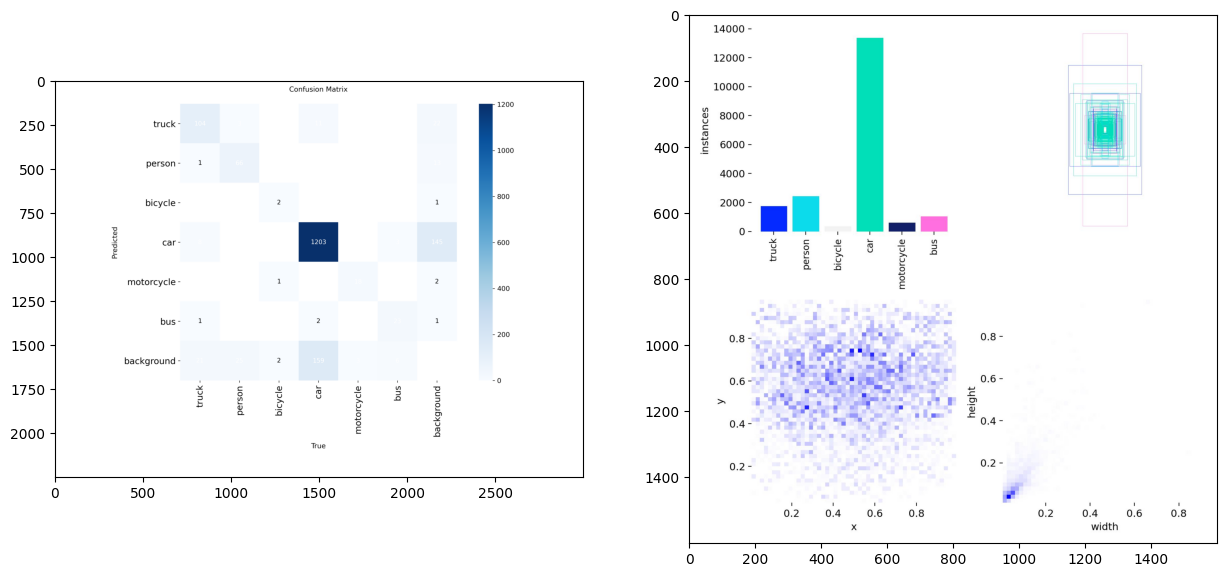

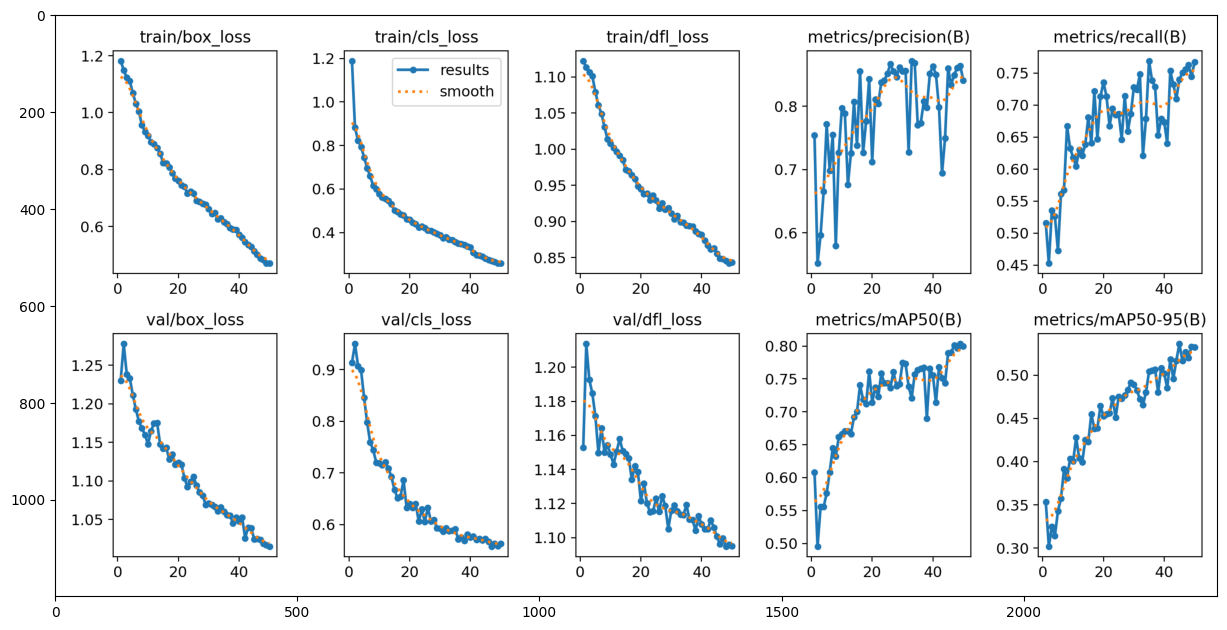

*************** Predicting Outcome  for: fold3***************

image 1/1 /kaggle/working/dawn/images/foggy-051.jpg: 384x640 1 truck, 1 car, 1 motorcycle, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold3_frist time

image 1/1 /kaggle/working/dawn/images/mist-152.jpg: 384x640 4 cars, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold3_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-009.jpg: 448x640 7 cars, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/custom_preds_fold3_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-149.jpg: 352x640 2 persons, 4 cars, 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/custom_preds_fold3_fri

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.869      0.746      0.837      0.587
                 truck         61        135      0.776       0.77      0.769      0.561
                person         42         94      0.904        0.7      0.829      0.583
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.904      0.859      0.916      0.696
            motorcycle         10         21      0.828      0.857       0.93      0.649
                   bus         21         32      0.803      0.688      0.777      0.688
Speed: 1.0ms preprocess, 7.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.1 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.867      0.743      0.837      0.587
                 truck         61        135      0.775      0.764      0.769      0.561
                person         42         94      0.891      0.692      0.827      0.581
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.903      0.858      0.917      0.695
            motorcycle         10         21       0.83      0.857       0.93      0.649
                   bus         21         32      0.805      0.688      0.777      0.688
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.1 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.862      0.744      0.836      0.586
                 truck         61        135      0.769      0.766      0.767      0.559
                person         42         94      0.867      0.694      0.825      0.576
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.902       0.86      0.917      0.695
            motorcycle         10         21       0.83      0.857       0.93      0.649
                   bus         21         32      0.805      0.688      0.777      0.688
Speed: 0.9ms preprocess, 7.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.1 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.871      0.746      0.832      0.589
                 truck         61        135      0.775       0.77      0.775       0.57
                person         42         94      0.904      0.701      0.825      0.591
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.904      0.859      0.911      0.698
            motorcycle         10         21      0.827      0.857      0.895      0.634
                   bus         21         32      0.815      0.688      0.786      0.697
Speed: 1.3ms preprocess, 7.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.2 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.869      0.745      0.832      0.589
                 truck         61        135      0.776       0.77      0.774      0.569
                person         42         94      0.891      0.697      0.824      0.589
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.902       0.86      0.912      0.698
            motorcycle         10         21      0.828      0.857      0.895      0.634
                   bus         21         32      0.815      0.688      0.786      0.697
Speed: 1.4ms preprocess, 7.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.2 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/val/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        206       1662      0.864      0.745      0.831      0.588
                 truck         61        135       0.77      0.768      0.774      0.568
                person         42         94      0.867      0.696      0.818      0.585
               bicycle          4          5          1        0.6        0.8      0.346
                   car        201       1375      0.901       0.86      0.913      0.699
            motorcycle         10         21      0.829      0.857      0.895      0.634
                   bus         21         32      0.815      0.688      0.786      0.697
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/validation_fold3
*************** Outcome With  conf: 0.2 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold3/weather/foggy/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1375.49it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold3/weather/foggy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         56        370      0.925      0.736      0.841      0.649
                 truck         16         30      0.783      0.721       0.75      0.591
                person          9         17      0.928      0.765      0.856      0.627
               bicycle          2          3          1      0.333      0.667      0.467
                   car         54        300      0.946      0.822      0.909      0.689
            motorcycle          2          2          1          1      0.995      0.784
                   bus          9         18      0.895      0.778      0.867      0.735
Speed: 3.8ms preprocess, 8.7ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/Fold_fold3_frist time_Weather_foggy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1284.5±571

val: Scanning /kaggle/working/augmented_dawn/fold3/weather/rainy/labels... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<00:00, 1296.27it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold3/weather/rainy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         42        397      0.849      0.607      0.746      0.582
                 truck         14         44      0.885      0.697      0.865      0.615
                person          5          7      0.924      0.429      0.599      0.428
                   car         41        344       0.92      0.802      0.897      0.661
                   bus          2          2      0.669        0.5      0.622      0.622
Speed: 4.5ms preprocess, 14.0ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs/Fold_fold3_frist time_Weather_rainy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1633.2±669.1 MB/s, size: 122.2 KB)


val: Scanning /kaggle/working/augmented_dawn/fold3/weather/snowy/labels... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<00:00, 1344.75it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold3/weather/snowy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         42        387      0.827      0.714      0.817      0.631
                 truck          8         18      0.703      0.658      0.675      0.465
                person         12         28       0.91      0.393      0.687      0.433
                   car         42        338      0.946      0.805       0.91      0.701
                   bus          2          3       0.75          1      0.995      0.924
Speed: 3.4ms preprocess, 7.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/Fold_fold3_frist time_Weather_snowy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1350.2±211.3 MB/s, size: 135.1 KB)


val: Scanning /kaggle/working/augmented_dawn/fold3/weather/sand/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1292.67it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold3/weather/sand/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         66        508      0.831      0.813      0.857      0.582
                 truck         23         43      0.758      0.791      0.783       0.58
                person         16         42      0.898      0.905      0.938      0.682
               bicycle          2          2          1          1      0.995      0.324
                   car         64        393      0.908      0.893      0.942      0.725
            motorcycle          8         19      0.817      0.842      0.919      0.634
                   bus          8          9      0.603      0.444      0.567      0.549
Speed: 3.0ms preprocess, 7.2ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/Fold_fold3_frist time_Weather_sand
                fold weather   mAP@0.5   map5095  inference_time(ms)  \
0   fold1_frist time   foggy  0.886637  0.662417            8.323134   
1   fold1_frist time   rainy  0.791193  0.599470           12.221686   
2   fold1_frist time  

In [59]:
train_and_evaluate("fold3","false","frist time")

## Fold4

************************* Data Preparation Started for: fold4_frist time*************************
/kaggle/working/augmented_dawn/fold4/weather Folder Created Succesfully
Weather is: foggy
/kaggle/working/augmented_dawn/fold4/weather/foggy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/foggy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/foggy/labels Folder Created Succesfully
Weather is: rainy
/kaggle/working/augmented_dawn/fold4/weather/rainy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/rainy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/rainy/labels Folder Created Succesfully
Weather is: snowy
/kaggle/working/augmented_dawn/fold4/weather/snowy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/snowy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold4/weather/snowy/labels Folder Created Succesfully
Weather is: sand
/kaggle/working

train: Scanning /kaggle/working/augmented_dawn/fold4/train/labels... 2236 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2236/2236 [00:04<00:00, 493.29it/s]

train: New cache created: /kaggle/working/augmented_dawn/fold4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 312.3±107.4 MB/s, size: 125.8 KB)


val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 1149.24it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold4/val/labels.cache


Plotting labels to runs/train_fold4_frist time/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train_fold4_frist time
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.71G      1.184      1.207      1.113        164        640: 100%|██████████| 140/140 [01:29<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.645      0.496      0.545       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.73G      1.133     0.8514      1.106        156        640: 100%|██████████| 140/140 [01:27<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1509       0.66      0.395      0.453      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.79G       1.14     0.8426       1.11        146        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        205       1509      0.595      0.455      0.493      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.86G      1.087     0.7718       1.09        382        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1509      0.661      0.481      0.535      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.93G      1.073     0.7428      1.079        161        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1509      0.716      0.476      0.549      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.87G      1.023     0.6876      1.062        167        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1509      0.607      0.481      0.533      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.87G     0.9993     0.6636      1.045        189        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        205       1509      0.728      0.483      0.545      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.89G     0.9697     0.6398      1.035        183        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        205       1509      0.709      0.496      0.559      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.95G     0.9557     0.6088      1.025        212        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.647      0.547      0.597      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.04G     0.9102     0.5823      1.006        182        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        205       1509       0.63      0.574      0.614      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.76G     0.8979     0.5625      1.002        129        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.746      0.525      0.608       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.8G     0.8916     0.5567     0.9997        207        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1509      0.745      0.535      0.635      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.87G     0.8714     0.5422     0.9914        176        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509       0.71      0.525      0.604      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.94G     0.8334     0.5112     0.9835        186        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        205       1509      0.668      0.553       0.62      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.05G     0.8419     0.5154     0.9776        167        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.662      0.557      0.647      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.73G     0.8163     0.4983      0.969        131        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.761      0.609      0.655      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.79G     0.8083     0.4838     0.9604        159        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.649      0.539      0.626      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.85G     0.7978     0.4799     0.9599        216        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        205       1509      0.722      0.521      0.631      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.92G     0.7812     0.4675      0.956        146        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        205       1509      0.675      0.556      0.654      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.87G     0.7653     0.4589     0.9458        159        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.716      0.572      0.659      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.87G     0.7525     0.4519     0.9443        158        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509      0.823      0.577      0.667      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.94G     0.7472       0.44     0.9363        195        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        205       1509      0.802      0.537      0.673      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       7.8G     0.7335     0.4372     0.9373        128        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1509      0.761      0.501      0.645      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.84G      0.725     0.4295     0.9357        238        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509       0.71      0.603      0.665      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.9G     0.7223     0.4351     0.9355        225        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.742      0.591       0.68       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.97G     0.7105      0.419     0.9267        114        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.764       0.55      0.667      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.18G     0.7073     0.4149     0.9273        191        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.812      0.597       0.69      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.96G      0.691     0.4078     0.9259        147        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1509      0.877      0.619      0.715      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.94G     0.6914     0.3991     0.9189        170        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1509      0.742      0.631      0.685      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.94G     0.6756     0.3973     0.9117        201        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1509      0.749      0.625      0.687      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.72G     0.6678     0.3907     0.9081        147        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        205       1509       0.68      0.638      0.687      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.78G     0.6547     0.3842     0.9116         86        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.816      0.607      0.697      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.85G     0.6459      0.375     0.9045        218        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        205       1509      0.804      0.603      0.699      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.91G     0.6371     0.3674      0.903        245        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.696      0.645        0.7      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.98G      0.628     0.3629     0.8971        201        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1509      0.764      0.579      0.693      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.06G     0.6323     0.3645     0.9009        104        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        205       1509      0.809      0.564      0.693      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.96G     0.6108     0.3514     0.8931        113        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1509      0.771      0.605      0.681      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.74G     0.6071     0.3502     0.8923        104        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        205       1509      0.805      0.578       0.69      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.8G     0.5988     0.3472     0.8891        144        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1509      0.866      0.617      0.701      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.87G     0.5899      0.336     0.8868        217        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.855      0.611      0.715      0.477


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.94G     0.5755     0.3133     0.8747         79        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.857      0.625      0.702      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.02G     0.5695     0.3067     0.8722        127        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509        0.8      0.646      0.719      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.96G     0.5571     0.3044     0.8717         89        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1509      0.758      0.655      0.718      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.74G     0.5411     0.2956     0.8654        165        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        205       1509      0.838      0.629      0.697      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.81G     0.5322     0.2898     0.8608         82        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.803      0.654      0.726      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.88G     0.5289     0.2888     0.8611        174        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        205       1509      0.885      0.607      0.722      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.95G     0.5144     0.2786     0.8559        130        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        205       1509      0.815       0.63      0.716      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.03G     0.4977      0.271     0.8475        109        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.721      0.666      0.718      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.97G     0.4944     0.2693     0.8495         60        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        205       1509      0.798      0.608      0.716      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.96G     0.4899     0.2656     0.8487         79        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1509      0.852      0.625      0.726       0.49



50 epochs completed in 1.264 hours.
Optimizer stripped from runs/train_fold4_frist time/weights/last.pt, 52.0MB
Optimizer stripped from runs/train_fold4_frist time/weights/best.pt, 52.0MB

Validating runs/train_fold4_frist time/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.886      0.607      0.722      0.496
                 truck         62        129      0.814       0.62      0.758      0.523
                person         42        105      0.876      0.657       0.79      0.503
               bicycle          4          6      0.945      0.333       0.36      0.234
                   car        202       1220      0.905      0.856      0.921       0.68
            motorcycle          9         18      0.907      0.541      0.787      0.467
                   bus         21         31      0.868      0.636      0.718      0.571
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/train_fold4_frist time
*************** Plotting Result for: fold4***************


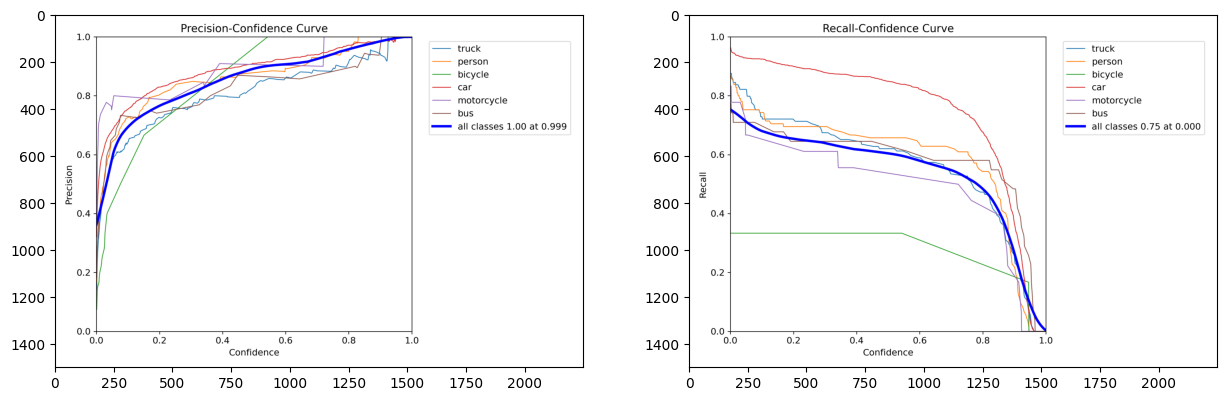

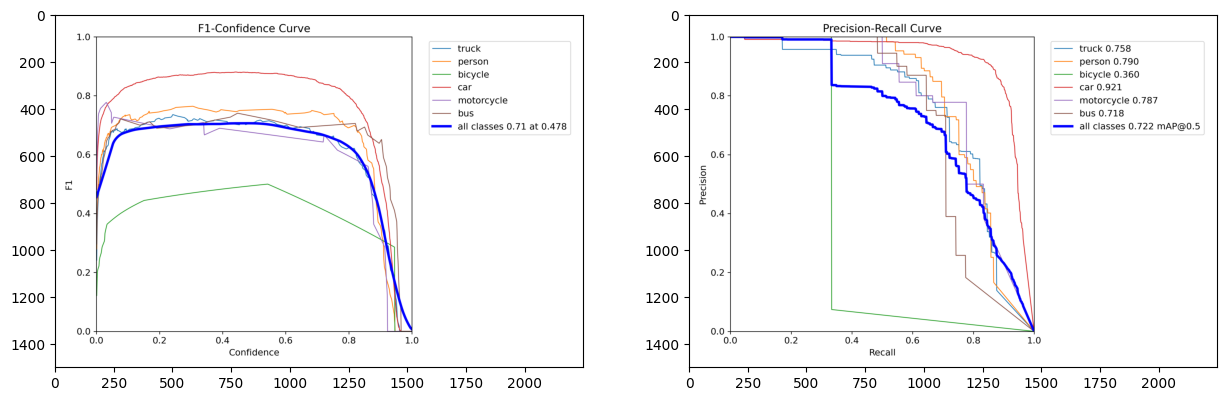

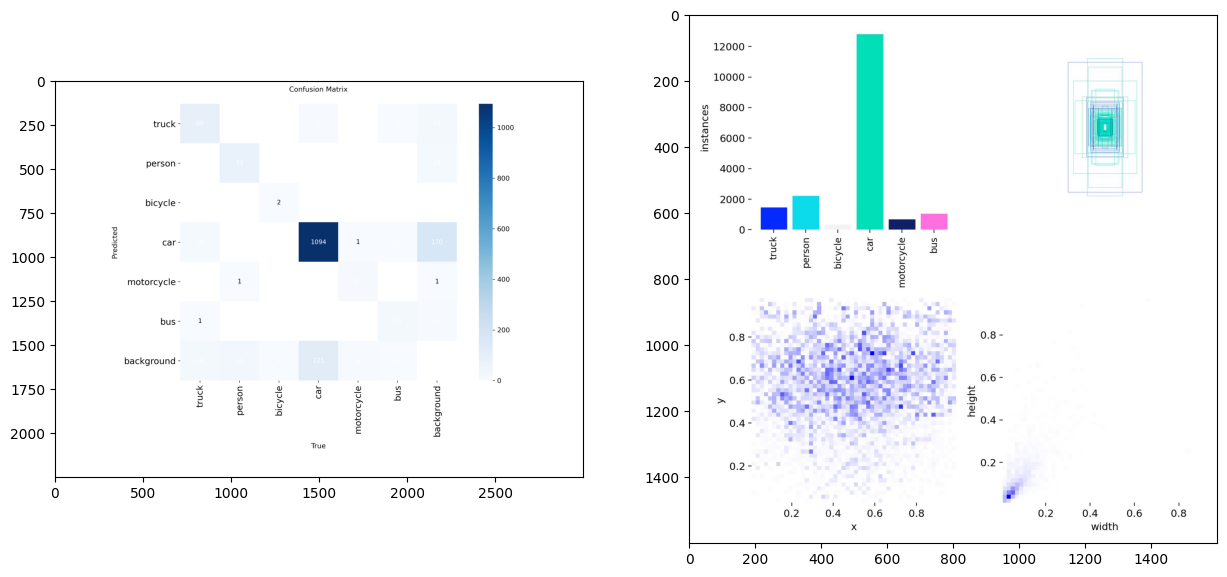

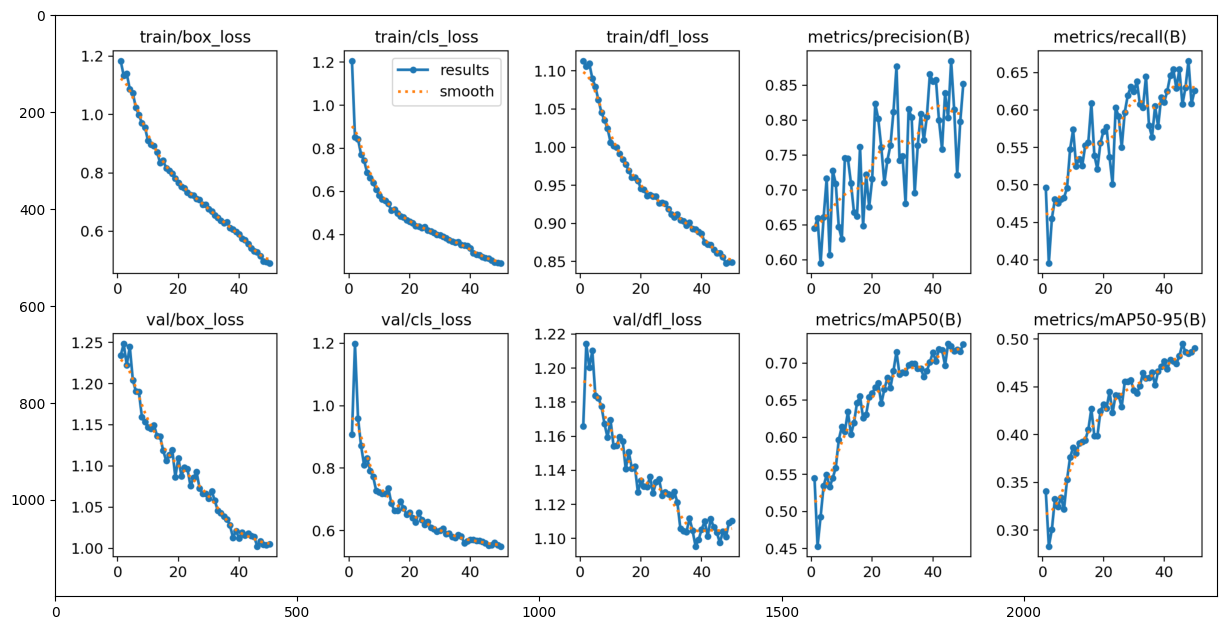

*************** Predicting Outcome  for: fold4***************

image 1/1 /kaggle/working/dawn/images/foggy-051.jpg: 384x640 1 truck, 1 car, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold4_frist time

image 1/1 /kaggle/working/dawn/images/mist-152.jpg: 384x640 4 cars, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold4_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-009.jpg: 448x640 7 cars, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/custom_preds_fold4_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-149.jpg: 352x640 2 persons, 4 cars, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/custom_preds_fold4_frist time

image

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.846      0.657      0.786      0.575
                 truck         62        129      0.764      0.705       0.76      0.564
                person         42        105       0.83      0.686      0.807      0.561
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220      0.858      0.885      0.921      0.711
            motorcycle          9         18      0.854      0.653      0.792      0.488
                   bus         21         31       0.77      0.677      0.772      0.635
Speed: 1.5ms preprocess, 7.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.1 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.845      0.657      0.786      0.575
                 truck         62        129      0.758      0.705      0.758      0.562
                person         42        105       0.83      0.686      0.807      0.561
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220      0.856      0.888      0.923      0.711
            motorcycle          9         18      0.854      0.653      0.792      0.488
                   bus         21         31       0.77      0.677      0.772      0.635
Speed: 1.0ms preprocess, 7.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.1 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.842      0.657      0.786      0.574
                 truck         62        129      0.748      0.705      0.756       0.56
                person         42        105      0.825      0.686      0.806       0.56
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220      0.854      0.891      0.925       0.71
            motorcycle          9         18      0.854      0.652      0.792      0.488
                   bus         21         31      0.772      0.677      0.772      0.635
Speed: 1.0ms preprocess, 7.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.1 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.844      0.659      0.786       0.58
                 truck         62        129      0.759      0.705      0.763      0.571
                person         42        105      0.821      0.686      0.798      0.573
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220       0.85      0.889      0.916      0.713
            motorcycle          9         18      0.856      0.661      0.792      0.488
                   bus         21         31      0.778      0.677       0.78      0.644
Speed: 1.1ms preprocess, 7.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.2 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509      0.843      0.659      0.786       0.58
                 truck         62        129      0.753      0.705      0.762       0.57
                person         42        105       0.82      0.686      0.798      0.573
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220      0.849      0.892      0.917      0.713
            motorcycle          9         18      0.856      0.661      0.792      0.488
                   bus         21         31      0.778      0.677       0.78      0.644
Speed: 1.0ms preprocess, 7.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.2 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1509       0.84      0.658      0.786      0.579
                 truck         62        129      0.743      0.705       0.76      0.568
                person         42        105      0.817      0.686      0.797      0.572
               bicycle          4          6          1      0.333      0.667      0.491
                   car        202       1220      0.849      0.893      0.919      0.713
            motorcycle          9         18      0.855      0.656      0.792      0.488
                   bus         21         31      0.778      0.677       0.78      0.644
Speed: 0.9ms preprocess, 7.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/validation_fold4
*************** Outcome With  conf: 0.2 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold4/weather/foggy/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 1307.24it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold4/weather/foggy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         65        367      0.762      0.528      0.652      0.493
                 truck         16         22      0.902      0.455       0.61       0.51
                person          8         24        0.8        0.5      0.734      0.461
               bicycle          1          3          0          0          0          0
                   car         64        305       0.96      0.786      0.933      0.716
            motorcycle          3          5      0.984        0.8      0.879      0.553
                   bus          6          8      0.926      0.625      0.759      0.718
Speed: 2.9ms preprocess, 10.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/Fold_fold4_frist time_Weather_foggy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1333.7±19

val: Scanning /kaggle/working/augmented_dawn/fold4/weather/rainy/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 985.13it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold4/weather/rainy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         34        251      0.438      0.516      0.518      0.389
                 truck         14         31      0.758      0.806      0.844      0.588
                person          4          4      0.333        0.5       0.58      0.483
                   car         34        212      0.764      0.939      0.944       0.74
            motorcycle          1          1          0          0          0          0
                   bus          3          3      0.333      0.333      0.222      0.133
Speed: 4.8ms preprocess, 8.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/Fold_fold4_frist time_Weather_rainy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1688.2±595.9 MB/s, size: 124.6 KB)


val: Scanning /kaggle/working/augmented_dawn/fold4/weather/snowy/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 1349.21it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold4/weather/snowy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         44        450       0.78      0.651      0.731      0.531
                 truck          9         33      0.729       0.57      0.686      0.433
                person         14         40      0.941        0.7      0.839      0.577
                   car         44        371      0.872      0.833      0.897      0.675
                   bus          5          6      0.576        0.5      0.502      0.436
Speed: 3.4ms preprocess, 12.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/Fold_fold4_frist time_Weather_snowy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1575.8±782.1 MB/s, size: 225.1 KB)


val: Scanning /kaggle/working/augmented_dawn/fold4/weather/sand/labels... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 1335.49it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold4/weather/sand/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         62        441      0.897      0.763      0.852      0.638
                 truck         23         43      0.866      0.814      0.828      0.654
                person         16         37      0.856      0.757      0.855       0.63
               bicycle          3          3          1      0.667      0.833      0.601
                   car         60        332      0.928      0.899      0.932      0.736
            motorcycle          5         12      0.875      0.583      0.745      0.498
                   bus          7         14      0.857      0.857      0.918      0.712
Speed: 3.1ms preprocess, 11.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/Fold_fold4_frist time_Weather_sand
                fold weather   mAP@0.5   map5095  inference_time(ms)  \
0   fold1_frist time   foggy  0.886637  0.662417            8.323134   
1   fold1_frist time   rainy  0.791193  0.599470           12.221686   
2   fold1_frist time 

In [60]:
train_and_evaluate("fold4","false","frist time")

## Fold5

************************* Data Preparation Started for: fold5_frist time*************************
/kaggle/working/augmented_dawn/fold5/weather Folder Created Succesfully
Weather is: foggy
/kaggle/working/augmented_dawn/fold5/weather/foggy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/foggy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/foggy/labels Folder Created Succesfully
Weather is: rainy
/kaggle/working/augmented_dawn/fold5/weather/rainy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/rainy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/rainy/labels Folder Created Succesfully
Weather is: snowy
/kaggle/working/augmented_dawn/fold5/weather/snowy Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/snowy/images Folder Created Succesfully
/kaggle/working/augmented_dawn/fold5/weather/snowy/labels Folder Created Succesfully
Weather is: sand
/kaggle/working

train: Scanning /kaggle/working/augmented_dawn/fold5/train/labels... 2230 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2230/2230 [00:04<00:00, 507.86it/s]


train: New cache created: /kaggle/working/augmented_dawn/fold5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 349.7±95.3 MB/s, size: 165.8 KB)


val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 1274.38it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold5/val/labels.cache


Plotting labels to runs/train_fold5_frist time/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train_fold5_frist time
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.69G      1.191      1.189      1.108        111        640: 100%|██████████| 140/140 [01:29<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

                   all        205       1523      0.539      0.334      0.321      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.75G      1.156     0.8891      1.115        131        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        205       1523      0.637      0.369      0.427      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.82G      1.138     0.8466      1.106        101        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        205       1523      0.753      0.407      0.493      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.89G      1.099     0.7789      1.097         87        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        205       1523      0.663      0.425      0.473       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.96G      1.061     0.7364       1.08         49        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        205       1523      0.659      0.456      0.494        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.85G      1.042     0.6972      1.069        133        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        205       1523      0.778      0.506      0.572      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.85G      1.016     0.6714      1.051         96        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1523      0.686       0.52      0.582      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.88G     0.9736     0.6341      1.036        112        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        205       1523      0.726      0.494      0.573      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.95G     0.9412     0.6073      1.024        104        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        205       1523      0.825       0.53      0.595      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.04G     0.9378     0.5881       1.02         62        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        205       1523      0.715      0.486      0.548      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.97G      0.897     0.5651      1.007         74        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        205       1523      0.634      0.561      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.79G     0.8774     0.5542     0.9954         99        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1523      0.693      0.534      0.592      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.85G     0.8645     0.5405     0.9932         86        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1523      0.738      0.617       0.69      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.92G     0.8611     0.5297     0.9893        121        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1523      0.822      0.518      0.603       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.99G      0.828     0.5139     0.9787        114        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1523      0.723      0.552      0.606       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.04G     0.8193     0.4987     0.9729         43        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        205       1523      0.812      0.521      0.629      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.97G     0.8071      0.492     0.9665         55        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1523      0.662      0.605      0.617      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.72G     0.7915     0.4749     0.9573         95        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        205       1523      0.751      0.558      0.665      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.79G     0.7823     0.4691     0.9529         89        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        205       1523      0.821      0.538      0.619      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.85G      0.765     0.4606     0.9488         71        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1523      0.702      0.607      0.643      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.92G     0.7667     0.4575      0.954         97        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        205       1523      0.867      0.572       0.67      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.99G      0.747     0.4473     0.9423         84        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1523      0.799      0.587      0.675      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.07G     0.7372     0.4378     0.9355        141        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1523      0.686      0.598      0.657      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.73G     0.7236     0.4333     0.9334         79        640: 100%|██████████| 140/140 [01:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        205       1523      0.702      0.647      0.704      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.79G     0.7177     0.4309     0.9313         78        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        205       1523      0.644      0.612      0.641      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.86G     0.7075     0.4183     0.9286        120        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        205       1523      0.656      0.635      0.663      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.92G     0.7025     0.4163     0.9245        147        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1523      0.866      0.556      0.663      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.04G     0.6915     0.4096     0.9235         91        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        205       1523      0.679      0.734      0.739      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.74G     0.6702     0.3971     0.9158         73        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        205       1523      0.662      0.643      0.687       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.8G     0.6627     0.3948     0.9155         69        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        205       1523        0.8       0.62      0.678      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.87G     0.6591     0.3948     0.9133         68        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        205       1523      0.761      0.671      0.699       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.94G     0.6626     0.3837     0.9106         99        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        205       1523      0.799      0.566      0.657      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.03G     0.6348     0.3729     0.9036         94        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        205       1523      0.785      0.584      0.664      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.96G     0.6254     0.3681     0.9016         55        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        205       1523      0.781      0.615      0.693      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.96G     0.6277     0.3681     0.9037        156        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        205       1523       0.84       0.65      0.714      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.96G     0.6037     0.3545     0.8926         73        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        205       1523      0.853      0.595      0.681      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.76G     0.6065     0.3544     0.8931        142        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        205       1523        0.8      0.684      0.713      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.82G     0.5957     0.3475     0.8909         99        640: 100%|██████████| 140/140 [01:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        205       1523      0.833      0.652      0.722      0.461
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 28, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



38 epochs completed in 0.959 hours.
Optimizer stripped from runs/train_fold5_frist time/weights/last.pt, 52.0MB
Optimizer stripped from runs/train_fold5_frist time/weights/best.pt, 52.0MB

Validating runs/train_fold5_frist time/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.679      0.734      0.739      0.466
                 truck         62        142      0.689      0.775      0.779      0.541
                person         42         95      0.682      0.621      0.639      0.372
               bicycle          4          6       0.64      0.667      0.542      0.218
                   car        202       1230      0.822      0.909      0.932      0.663
            motorcycle          9         20      0.675        0.7      0.767      0.379
                   bus         22         30      0.566      0.733      0.773      0.625
Speed: 0.1ms preprocess, 7.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/train_fold5_frist time
*************** Plotting Result for: fold5***************


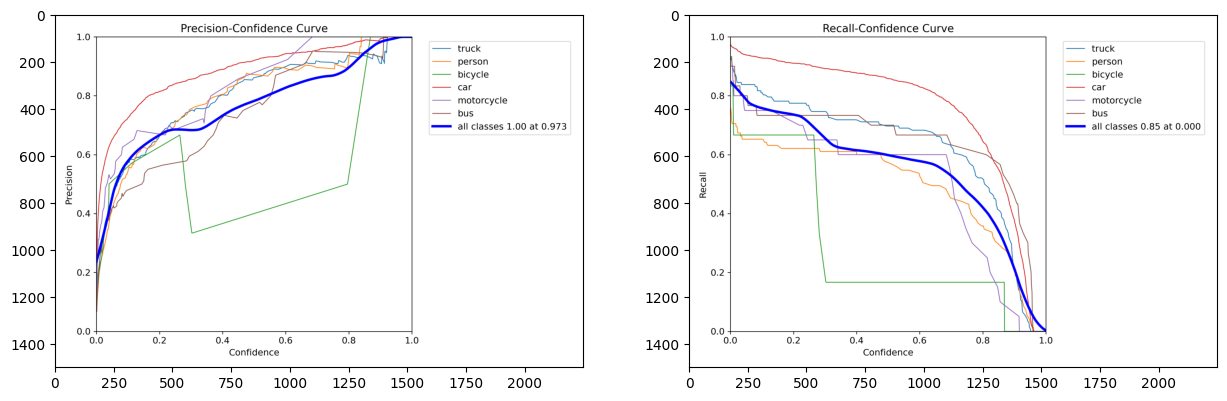

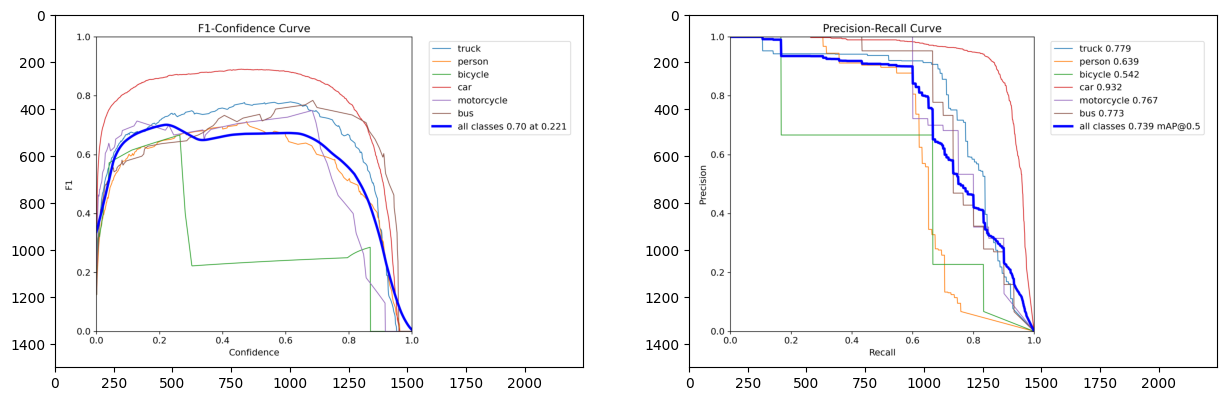

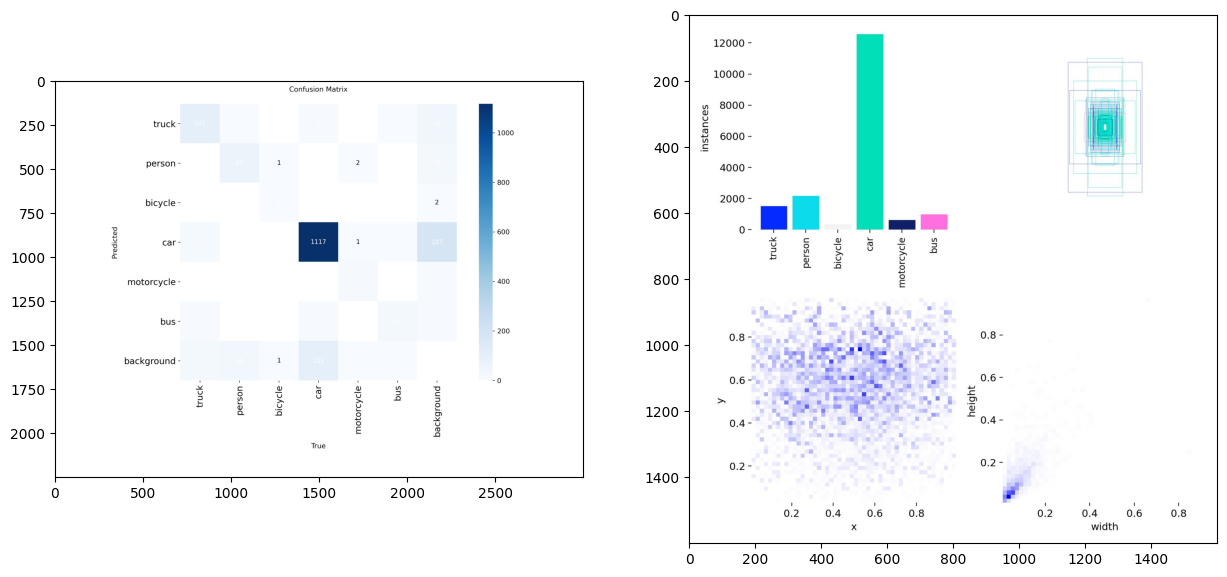

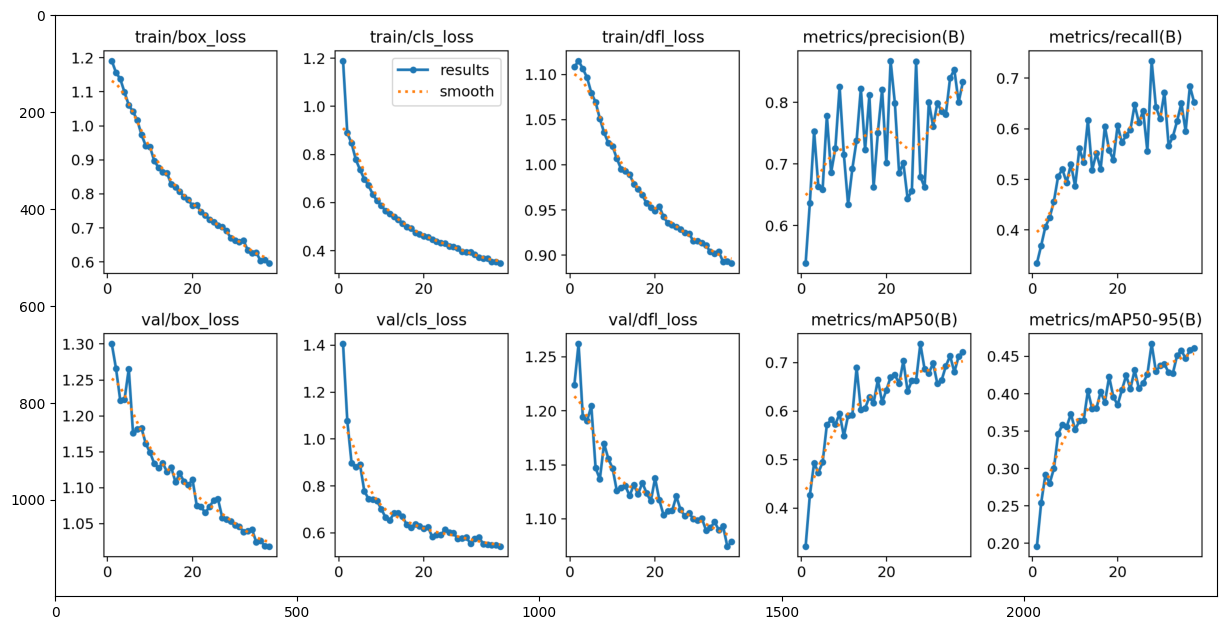

*************** Predicting Outcome  for: fold5***************

image 1/1 /kaggle/working/dawn/images/foggy-051.jpg: 384x640 1 truck, 1 car, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold5_frist time

image 1/1 /kaggle/working/dawn/images/mist-152.jpg: 384x640 3 cars, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/custom_preds_fold5_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-009.jpg: 448x640 1 truck, 8 cars, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/custom_preds_fold5_frist time

image 1/1 /kaggle/working/dawn/images/snow_storm-149.jpg: 352x640 2 persons, 3 cars, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/custom_preds_fold5_frist ti

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.703      0.734      0.769      0.513
                 truck         62        142      0.724      0.775      0.803      0.583
                person         42         95      0.705      0.621      0.718      0.448
               bicycle          4          6      0.642      0.667      0.595       0.27
                   car        202       1230      0.856      0.906      0.932      0.697
            motorcycle          9         20      0.726        0.7      0.793       0.43
                   bus         22         30      0.566      0.733      0.771      0.648
Speed: 1.1ms preprocess, 7.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.1 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.701      0.734      0.768      0.512
                 truck         62        142      0.715      0.775      0.801      0.581
                person         42         95      0.705      0.621      0.715      0.446
               bicycle          4          6      0.642      0.667      0.595       0.27
                   car        202       1230      0.852      0.907      0.933      0.697
            motorcycle          9         20      0.726        0.7      0.793       0.43
                   bus         22         30      0.566      0.733      0.771      0.648
Speed: 1.4ms preprocess, 7.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.1 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.695      0.734      0.766       0.51
                 truck         62        142       0.71      0.775        0.8       0.58
                person         42         95       0.69      0.621      0.709      0.441
               bicycle          4          6      0.642      0.667      0.595       0.27
                   car        202       1230       0.84      0.908      0.932      0.696
            motorcycle          9         20      0.726        0.7      0.789      0.427
                   bus         22         30      0.566      0.733      0.771      0.648
Speed: 1.0ms preprocess, 7.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.1 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.704      0.734       0.77       0.52
                 truck         62        142      0.717      0.775      0.798      0.586
                person         42         95      0.704      0.621      0.722      0.459
               bicycle          4          6      0.667      0.667      0.611      0.279
                   car        202       1230      0.853      0.907      0.928        0.7
            motorcycle          9         20      0.718        0.7      0.777      0.435
                   bus         22         30      0.565      0.733      0.781      0.658
Speed: 1.4ms preprocess, 7.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.2 & iou: 0.4***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.702      0.734      0.769      0.519
                 truck         62        142      0.708      0.775      0.796      0.585
                person         42         95      0.704      0.621      0.722      0.459
               bicycle          4          6      0.667      0.667      0.611      0.279
                   car        202       1230      0.849      0.908      0.929        0.7
            motorcycle          9         20      0.718        0.7      0.777      0.435
                   bus         22         30      0.565      0.733      0.781      0.658
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.2 & iou: 0.5***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/val/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        205       1523      0.697      0.734      0.768      0.519
                 truck         62        142      0.705      0.775      0.796      0.584
                person         42         95      0.688      0.621      0.718      0.456
               bicycle          4          6      0.667      0.667      0.611      0.279
                   car        202       1230      0.837      0.909      0.928        0.7
            motorcycle          9         20      0.719        0.7      0.777      0.435
                   bus         22         30      0.565      0.733      0.781      0.658
Speed: 0.9ms preprocess, 7.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/validation_fold5
*************** Outcome With  conf: 0.2 & iou: 0.6***************
    conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889

val: Scanning /kaggle/working/augmented_dawn/fold5/weather/foggy/labels... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 1304.83it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold5/weather/foggy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         57        476      0.878      0.653      0.805      0.552
                 truck         17         43      0.883      0.701      0.843      0.622
                person         11         30        0.8      0.633      0.753       0.49
               bicycle          3          5          1       0.34      0.749      0.389
                   car         57        377      0.922      0.905      0.951      0.708
            motorcycle          4          7      0.768      0.714      0.794      0.492
                   bus          7         14      0.897      0.625      0.737      0.612
Speed: 3.5ms preprocess, 8.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/Fold_fold5_frist time_Weather_foggy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1152.6±225

val: Scanning /kaggle/working/augmented_dawn/fold5/weather/rainy/labels... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 1166.74it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold5/weather/rainy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         43        288      0.881      0.759      0.862      0.586
                 truck         16         40      0.964        0.8      0.892       0.65
                person          5          7      0.827      0.688      0.852      0.526
                   car         41        234       0.95      0.893      0.956      0.702
            motorcycle          2          3          1      0.667      0.833      0.433
                   bus          4          4      0.666       0.75      0.777      0.619
Speed: 5.1ms preprocess, 12.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/Fold_fold5_frist time_Weather_rainy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1506.9±550.2 MB/s, size: 130.0 KB)


val: Scanning /kaggle/working/augmented_dawn/fold5/weather/snowy/labels... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1277.54it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold5/weather/snowy/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         41        338      0.841      0.765      0.827      0.642
                 truck         12         22      0.817      0.682      0.778        0.6
                person         10         19      0.881      0.579      0.715      0.532
                   car         41        294      0.918      0.801      0.904      0.665
                   bus          2          3       0.75          1      0.913      0.772
Speed: 4.0ms preprocess, 10.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/Fold_fold5_frist time_Weather_snowy
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 974.0±554.3 MB/s, size: 58.3 KB)


val: Scanning /kaggle/working/augmented_dawn/fold5/weather/sand/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00:00<00:00, 1183.73it/s]

val: New cache created: /kaggle/working/augmented_dawn/fold5/weather/sand/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         64        421      0.698      0.757      0.741      0.456
                 truck         17         37      0.608      0.703      0.691       0.48
                person         16         39      0.768      0.538      0.682      0.377
               bicycle          1          1      0.487      0.973      0.497     0.0498
                   car         63        325       0.88       0.88      0.925      0.716
            motorcycle          3         10       0.87       0.67      0.855       0.44
                   bus          9          9      0.577      0.778      0.797      0.676
Speed: 2.8ms preprocess, 7.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/Fold_fold5_frist time_Weather_sand
                fold weather   mAP@0.5   map5095  inference_time(ms)  \
0   fold1_frist time   foggy  0.886637  0.662417            8.323134   
1   fold1_frist time   rainy  0.791193  0.599470           12.221686   
2   fold1_frist time  

In [61]:
train_and_evaluate("fold5","false","frist time")

## Clear Spcae

In [62]:
def delete_files_only(directory_path):
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)

# Example usage
delete_files_only('/kaggle/working/')  # Replace with your actual path

In [63]:
def list_folders(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# Example usage
path = '/kaggle/working/'  # replace with your desired path
folders = list_folders(path)
for folder in folders:
    folder_path=os.path.join('/kaggle/working/',folder)
    if(folder=="runs"):
        print(f"{ folder_path} is output folder")
    else:
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            shutil.rmtree(folder_path)
            print(f"Deleted folder: {folder_path}")

Deleted folder: /kaggle/working/dawn
Deleted folder: /kaggle/working/augmented_dawn
/kaggle/working/runs is output folder
Deleted folder: /kaggle/working/dawn_5_fold


# Final Outcome

In [64]:
df = pd.DataFrame(fold_result,
                        columns=["conf","iou","map50", "map", "inference_time",
                        "average_precision","average_recall","average_f1_score"])

df

conf  iou     map50       map  inference_time  average_precision  \
0    0.1  0.4  0.869838  0.651409        7.954512           0.844890   
1    0.1  0.5  0.870157  0.651215        7.889638           0.844944   
2    0.1  0.6  0.869594  0.651255        7.767931           0.840638   
3    0.2  0.4  0.864149  0.652175        7.172032           0.845081   
4    0.2  0.5  0.864389  0.651950        7.424151           0.845134   
5    0.2  0.6  0.863822  0.651946        7.181113           0.853254   
6    0.1  0.4  0.754525  0.513837        8.192022           0.776170   
7    0.1  0.5  0.754918  0.513713        7.089508           0.776077   
8    0.1  0.6  0.754707  0.513266        7.108194           0.778082   
9    0.2  0.4  0.736892  0.517109        7.736095           0.780811   
10   0.2  0.5  0.736779  0.516911        7.222007           0.780720   
11   0.2  0.6  0.736254  0.516438        7.158485           0.781561   
12   0.1  0.4  0.836808  0.587036        7.446453           0.869065   
13   0.1  0.5  0.836516  0.586622        7.443604           0.867337   
14   0.1  0.6  0.836140  0.585597        7.171523           0.862179   
15   0.2  0.4  0.832201  0.589283        7.706704           0.870838   
16   0.2  0.5  0.831876  0.588859        7.416115           0.868799   
17   0.2  0.6  0.831017  0.588119        7.480757           0.863714   
18   0.1  0.4  0.786477  0.575085        7.483229           0.846149   
19   0.1  0.5  0.786311  0.574627        7.805895           0.844805   
20   0.1  0.6  0.786092  0.574126        7.444974           0.842309   
21   0.2  0.4  0.786209  0.580066        7.244529           0.843998   
22   0.2  0.5  0.786156  0.579871        7.242847           0.842574   
23   0.2  0.6  0.785761  0.579300        7.431040           0.840262   
24   0.1  0.4  0.768612  0.512546        7.664052           0.703056   
25   0.1  0.5  0.768059  0.511945        7.794999           0.700871   
26   0.1  0.6  0.765933  0.510218        7.313100           0.695446   
27   0.2  0.4  0.769511  0.519547        7.410519           0.703900   
28   0.2  0.5  0.769381  0.519362        7.458065           0.701750   
29   0.2  0.6  0.768499  0.518660        7.436387           0.696724   

    average_recall  average_f1_score  
0         0.806332          0.820852  
1         0.806950          0.821211  
2         0.806868          0.819015  
3         0.805669          0.820570  
4         0.806287          0.820929  
5         0.801778          0.822559  
6         0.616331          0.673360  
7         0.616724          0.673535  
8         0.616495          0.673947  
9         0.616980          0.677132  
10        0.617373          0.677306  
11        0.616724          0.676874  
12        0.745722          0.796023  
13        0.743038          0.793874  
14        0.744026          0.792277  
15        0.745834          0.796825  
16        0.745204          0.795660  
17        0.744775          0.793320  
18        0.656675          0.719518  
19        0.657084          0.719079  
20        0.657428          0.718069  
21        0.658644          0.719623  
22        0.659144          0.719195  
23        0.658458          0.717699  
24        0.733565          0.715732  
25        0.733836          0.714689  
26        0.733972          0.712074  
27        0.733701          0.716209  
28        0.733972          0.715175  
29        0.734053          0.712736

In [65]:
grouped = df.groupby(df.index // 6)

# Get the best row in each group based on highest 'map50'
best_rows = grouped.apply(lambda x: x.loc[x['map50'].idxmax()])

# Reset index if needed
best_rows = best_rows.reset_index(drop=True)

best_rows

conf  iou     map50       map  inference_time  average_precision  \
0   0.1  0.5  0.870157  0.651215        7.889638           0.844944   
1   0.1  0.5  0.754918  0.513713        7.089508           0.776077   
2   0.1  0.4  0.836808  0.587036        7.446453           0.869065   
3   0.1  0.4  0.786477  0.575085        7.483229           0.846149   
4   0.2  0.4  0.769511  0.519547        7.410519           0.703900   

   average_recall  average_f1_score  
0        0.806950          0.821211  
1        0.616724          0.673535  
2        0.745722          0.796023  
3        0.656675          0.719518  
4        0.733701          0.716209

In [66]:
# Compute the average of the best rows
average_best = best_rows.mean(numeric_only=True)

print("Average of best rows:")
print(average_best)

Average of best rows:
conf                 0.120000
iou                  0.440000
map50                0.803574
map                  0.569319
inference_time       7.463870
average_precision    0.808027
average_recall       0.711954
average_f1_score     0.745299
dtype: float64


In [67]:
# Convert to DataFrame
df = pd.DataFrame(weather_result,
                columns=["fold","weather","mAP@0.5", "map5095","inference_time(ms)",
                         "precision","recall","f1_score"])
df

fold weather   mAP@0.5   map5095  inference_time(ms)  \
0   fold1_frist time   foggy  0.886637  0.662417            8.323134   
1   fold1_frist time   rainy  0.791193  0.599470           12.221686   
2   fold1_frist time   snowy  0.941390  0.692645           17.869410   
3   fold1_frist time    sand  0.873792  0.696679           10.788051   
4   fold2_frist time   foggy  0.860265  0.552348            8.768799   
5   fold2_frist time   rainy  0.752854  0.520879           13.217624   
6   fold2_frist time   snowy  0.854944  0.605053           12.562585   
7   fold2_frist time    sand  0.709216  0.461960            9.305321   
8   fold3_frist time   foggy  0.840604  0.648750            8.659685   
9   fold3_frist time   rainy  0.745842  0.581640           13.999813   
10  fold3_frist time   snowy  0.816688  0.630967            7.580201   
11  fold3_frist time    sand  0.857352  0.582055            7.218119   
12  fold4_frist time   foggy  0.652481  0.493237           10.204240   
13  fold4_frist time   rainy  0.518150  0.388794            8.289167   
14  fold4_frist time   snowy  0.731064  0.530520           12.025284   
15  fold4_frist time    sand  0.851785  0.638442           11.831144   
16  fold5_frist time   foggy  0.804520  0.552085            8.145798   
17  fold5_frist time   rainy  0.862066  0.586005           12.836823   
18  fold5_frist time   snowy  0.827080  0.642158           10.049441   
19  fold5_frist time    sand  0.741255  0.456378            7.743914   

    precision    recall  f1_score  
0    0.863994  0.795143  0.828140  
1    0.881343  0.651286  0.749048  
2    0.926813  0.891181  0.908648  
3    0.872964  0.816153  0.843603  
4    0.888821  0.780836  0.831337  
5    0.837723  0.652240  0.733436  
6    0.848343  0.753632  0.798188  
7    0.567551  0.727851  0.637783  
8    0.925375  0.736493  0.820200  
9    0.849267  0.606879  0.707899  
10   0.827195  0.713854  0.766356  
11   0.830546  0.812523  0.821436  
12   0.761918  0.527552  0.623437  
13   0.437574  0.515693  0.473432  
14   0.779526  0.650740  0.709335  
15   0.897238  0.762786  0.824567  
16   0.878258  0.653196  0.749189  
17   0.881345  0.759452  0.815871  
18   0.841424  0.765441  0.801636  
19   0.698305  0.757199  0.726560